<center><h1>2-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning : 
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2022-11-18 21:27:16--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2022-11-18 21:27:16--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2022-11-18 21:27:17 (55.3 MB/s) - ‘utils.py’ saved [2627/2627]



In [ ]:
%run 'utils.py'

In [2]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [11]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.155s (0.155s)	Loss 2.3038 (2.3038)	Prec@1   7.0 (  7.0)	Prec@5  46.1 ( 46.1)


<Figure size 432x288 with 0 Axes>

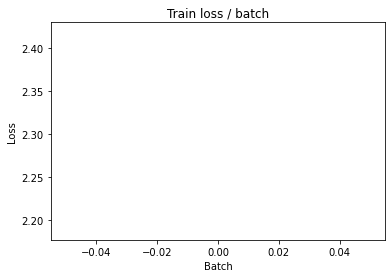

[TRAIN Batch 200/391]	Time 0.020s (0.019s)	Loss 2.3002 (2.2923)	Prec@1  13.3 ( 12.5)	Prec@5  51.6 ( 54.5)


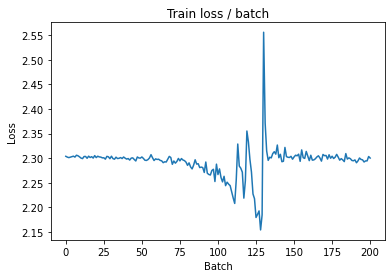


===============> Total time 7s	Avg loss 2.2573	Avg Prec@1 15.25 %	Avg Prec@5 59.84 %

[EVAL Batch 000/079]	Time 0.133s (0.133s)	Loss 2.0943 (2.0943)	Prec@1  28.1 ( 28.1)	Prec@5  80.5 ( 80.5)

===============> Total time 1s	Avg loss 2.0750	Avg Prec@1 25.62 %	Avg Prec@5 76.81 %



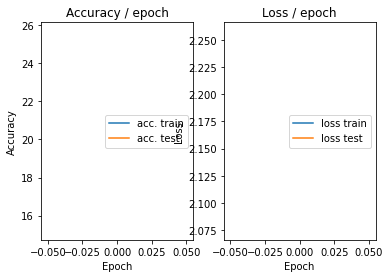

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 2.1341 (2.1341)	Prec@1  23.4 ( 23.4)	Prec@5  75.8 ( 75.8)


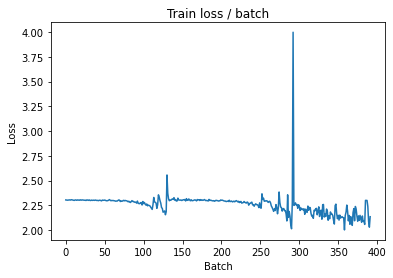

[TRAIN Batch 200/391]	Time 0.020s (0.020s)	Loss 2.1102 (2.0381)	Prec@1  19.5 ( 26.5)	Prec@5  73.4 ( 77.5)


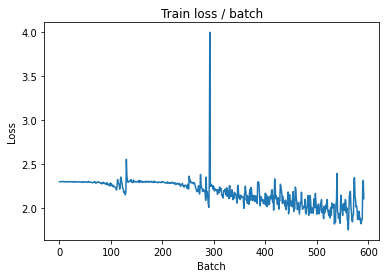


===============> Total time 7s	Avg loss 1.9510	Avg Prec@1 29.66 %	Avg Prec@5 80.78 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 1.8391 (1.8391)	Prec@1  25.0 ( 25.0)	Prec@5  87.5 ( 87.5)

===============> Total time 1s	Avg loss 1.9095	Avg Prec@1 30.91 %	Avg Prec@5 84.95 %



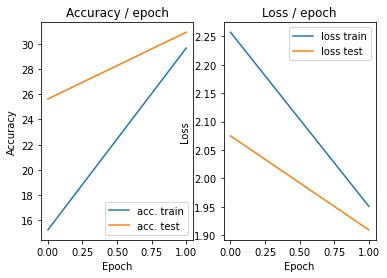

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 1.9682 (1.9682)	Prec@1  31.2 ( 31.2)	Prec@5  85.2 ( 85.2)


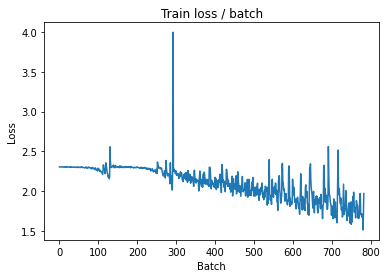

[TRAIN Batch 200/391]	Time 0.008s (0.020s)	Loss 1.3807 (1.6324)	Prec@1  53.9 ( 41.2)	Prec@5  96.1 ( 89.4)


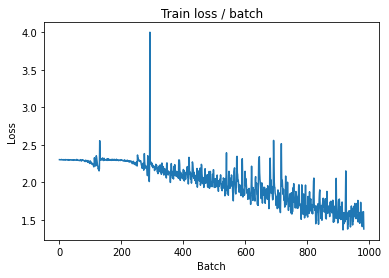


===============> Total time 7s	Avg loss 1.5779	Avg Prec@1 43.45 %	Avg Prec@5 90.17 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 1.5022 (1.5022)	Prec@1  49.2 ( 49.2)	Prec@5  91.4 ( 91.4)

===============> Total time 1s	Avg loss 1.4950	Avg Prec@1 45.96 %	Avg Prec@5 92.04 %



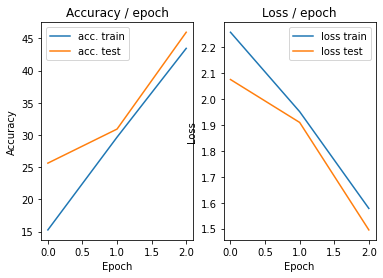

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.149s (0.149s)	Loss 1.4148 (1.4148)	Prec@1  51.6 ( 51.6)	Prec@5  92.2 ( 92.2)


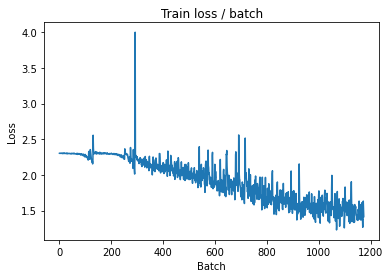

[TRAIN Batch 200/391]	Time 0.024s (0.021s)	Loss 1.4025 (1.4065)	Prec@1  45.3 ( 49.4)	Prec@5  95.3 ( 93.0)


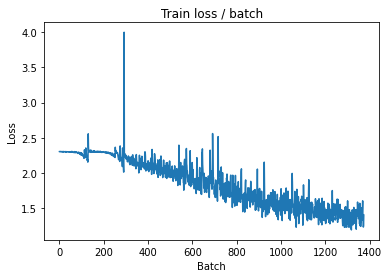


===============> Total time 8s	Avg loss 1.3838	Avg Prec@1 50.37 %	Avg Prec@5 93.23 %

[EVAL Batch 000/079]	Time 0.146s (0.146s)	Loss 1.4255 (1.4255)	Prec@1  53.1 ( 53.1)	Prec@5  94.5 ( 94.5)

===============> Total time 1s	Avg loss 1.4533	Avg Prec@1 49.08 %	Avg Prec@5 92.44 %



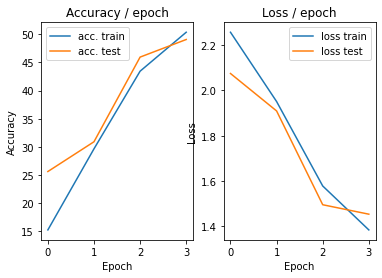

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 1.4159 (1.4159)	Prec@1  50.0 ( 50.0)	Prec@5  93.8 ( 93.8)


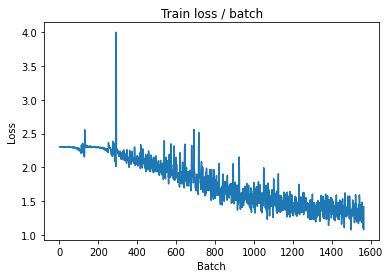

[TRAIN Batch 200/391]	Time 0.012s (0.019s)	Loss 1.2218 (1.2730)	Prec@1  56.2 ( 55.0)	Prec@5  95.3 ( 94.4)


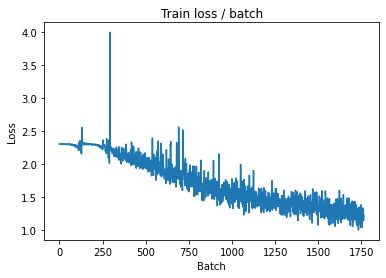


===============> Total time 7s	Avg loss 1.2511	Avg Prec@1 55.48 %	Avg Prec@5 94.52 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 1.2915 (1.2915)	Prec@1  53.1 ( 53.1)	Prec@5  93.0 ( 93.0)

===============> Total time 1s	Avg loss 1.2871	Avg Prec@1 53.41 %	Avg Prec@5 94.57 %



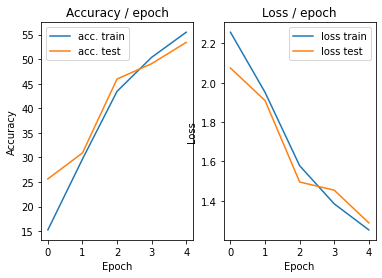

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 1.3587 (1.3587)	Prec@1  52.3 ( 52.3)	Prec@5  93.0 ( 93.0)


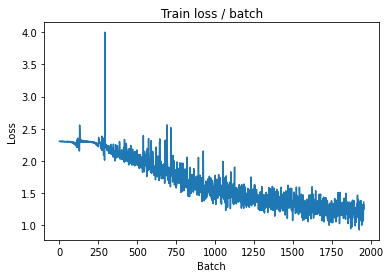

[TRAIN Batch 200/391]	Time 0.020s (0.019s)	Loss 1.1460 (1.1438)	Prec@1  57.0 ( 59.2)	Prec@5  96.1 ( 95.8)


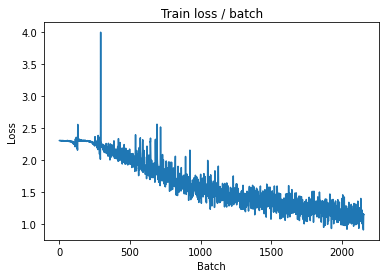


===============> Total time 7s	Avg loss 1.1242	Avg Prec@1 60.01 %	Avg Prec@5 95.91 %

[EVAL Batch 000/079]	Time 0.133s (0.133s)	Loss 1.0318 (1.0318)	Prec@1  62.5 ( 62.5)	Prec@5  94.5 ( 94.5)

===============> Total time 1s	Avg loss 1.1791	Avg Prec@1 58.79 %	Avg Prec@5 95.02 %



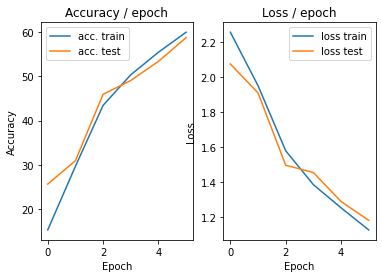

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.9038 (0.9038)	Prec@1  68.0 ( 68.0)	Prec@5  96.9 ( 96.9)


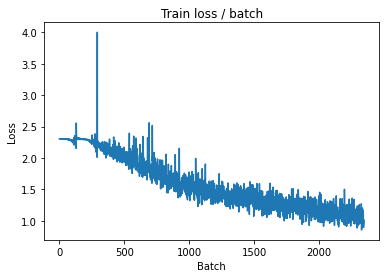

[TRAIN Batch 200/391]	Time 0.010s (0.020s)	Loss 0.8971 (1.0109)	Prec@1  68.8 ( 64.2)	Prec@5  98.4 ( 96.6)


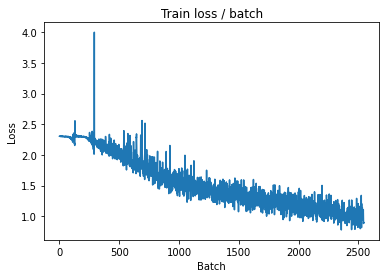


===============> Total time 7s	Avg loss 1.0030	Avg Prec@1 64.37 %	Avg Prec@5 96.74 %

[EVAL Batch 000/079]	Time 0.124s (0.124s)	Loss 1.0285 (1.0285)	Prec@1  64.8 ( 64.8)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0758	Avg Prec@1 62.12 %	Avg Prec@5 96.10 %



=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.149s (0.149s)	Loss 0.9282 (0.9282)	Prec@1  68.0 ( 68.0)	Prec@5  95.3 ( 95.3)


[TRAIN Batch 200/391]	Time 0.026s (0.019s)	Loss 0.7398 (0.9660)	Prec@1  75.8 ( 66.4)	Prec@5  98.4 ( 97.0)


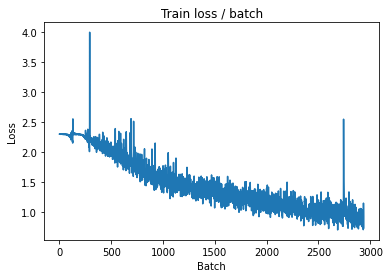


===============> Total time 7s	Avg loss 0.9241	Avg Prec@1 67.67 %	Avg Prec@5 97.29 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 0.9628 (0.9628)	Prec@1  71.9 ( 71.9)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.0096	Avg Prec@1 64.33 %	Avg Prec@5 96.80 %



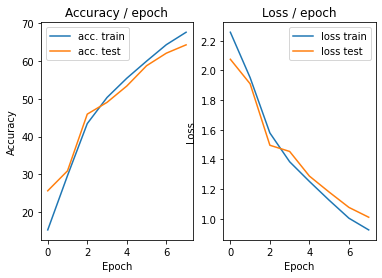

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.151s (0.151s)	Loss 0.7978 (0.7978)	Prec@1  75.0 ( 75.0)	Prec@5  96.9 ( 96.9)


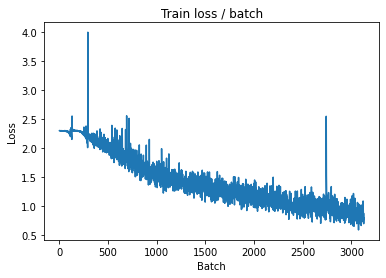

[TRAIN Batch 200/391]	Time 0.010s (0.019s)	Loss 0.7381 (0.8039)	Prec@1  72.7 ( 71.7)	Prec@5 100.0 ( 98.0)


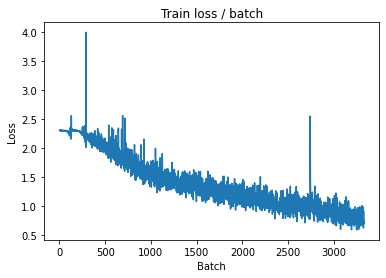


===============> Total time 7s	Avg loss 0.7986	Avg Prec@1 72.04 %	Avg Prec@5 98.07 %

[EVAL Batch 000/079]	Time 0.123s (0.123s)	Loss 0.9471 (0.9471)	Prec@1  70.3 ( 70.3)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 0.9383	Avg Prec@1 67.10 %	Avg Prec@5 96.96 %



=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 0.5809 (0.5809)	Prec@1  82.0 ( 82.0)	Prec@5  99.2 ( 99.2)


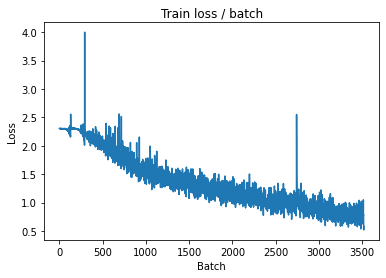

[TRAIN Batch 200/391]	Time 0.022s (0.019s)	Loss 0.5751 (0.6891)	Prec@1  84.4 ( 75.7)	Prec@5  99.2 ( 98.7)


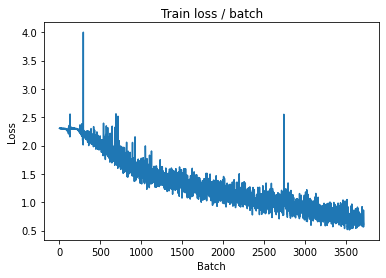


===============> Total time 7s	Avg loss 0.6977	Avg Prec@1 75.59 %	Avg Prec@5 98.62 %

[EVAL Batch 000/079]	Time 0.136s (0.136s)	Loss 0.9116 (0.9116)	Prec@1  71.1 ( 71.1)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 0.9738	Avg Prec@1 67.12 %	Avg Prec@5 96.62 %



=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.146s (0.146s)	Loss 0.6835 (0.6835)	Prec@1  75.0 ( 75.0)	Prec@5  98.4 ( 98.4)


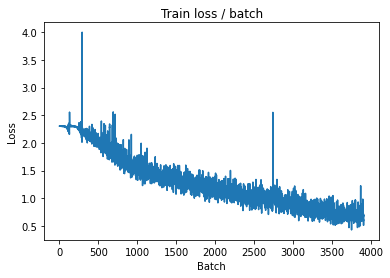

[TRAIN Batch 200/391]	Time 0.025s (0.019s)	Loss 0.5940 (0.5859)	Prec@1  77.3 ( 79.7)	Prec@5 100.0 ( 99.1)


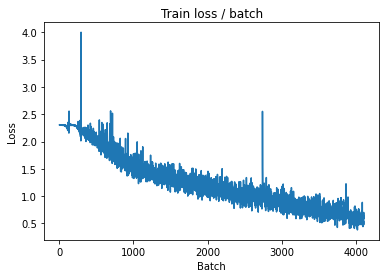


===============> Total time 7s	Avg loss 0.5970	Avg Prec@1 79.04 %	Avg Prec@5 99.09 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 0.9335 (0.9335)	Prec@1  71.1 ( 71.1)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 0.9917	Avg Prec@1 67.61 %	Avg Prec@5 96.63 %



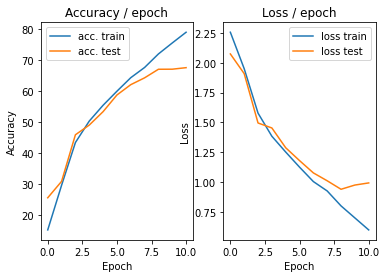

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.145s (0.145s)	Loss 0.4513 (0.4513)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


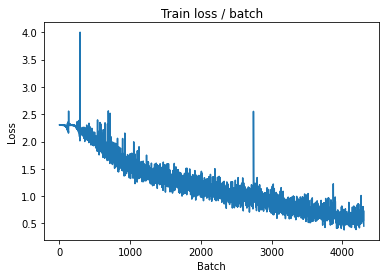

[TRAIN Batch 200/391]	Time 0.021s (0.021s)	Loss 0.5204 (0.4836)	Prec@1  80.5 ( 83.3)	Prec@5 100.0 ( 99.5)


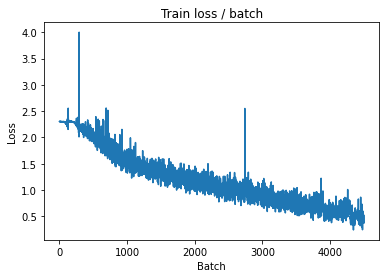


===============> Total time 7s	Avg loss 0.4997	Avg Prec@1 82.52 %	Avg Prec@5 99.42 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 1.0542 (1.0542)	Prec@1  70.3 ( 70.3)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.0477	Avg Prec@1 67.03 %	Avg Prec@5 96.88 %



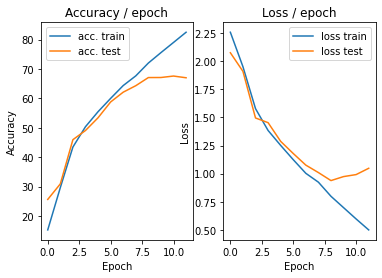

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.154s (0.154s)	Loss 0.4008 (0.4008)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


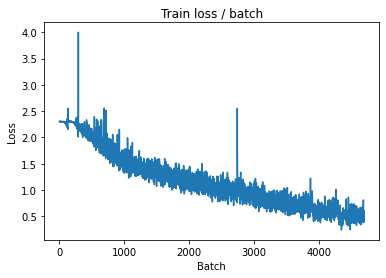

[TRAIN Batch 200/391]	Time 0.020s (0.019s)	Loss 0.4514 (0.3855)	Prec@1  82.8 ( 86.6)	Prec@5 100.0 ( 99.7)


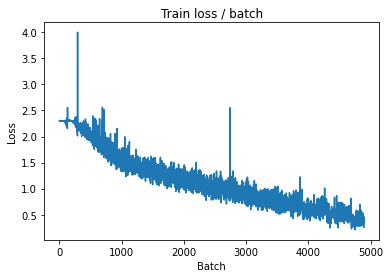


===============> Total time 7s	Avg loss 0.4019	Avg Prec@1 85.93 %	Avg Prec@5 99.67 %

[EVAL Batch 000/079]	Time 0.134s (0.134s)	Loss 1.2125 (1.2125)	Prec@1  68.0 ( 68.0)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.2057	Avg Prec@1 64.20 %	Avg Prec@5 96.20 %



=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 0.4618 (0.4618)	Prec@1  82.8 ( 82.8)	Prec@5 100.0 (100.0)


[TRAIN Batch 200/391]	Time 0.019s (0.020s)	Loss 0.3634 (0.2978)	Prec@1  88.3 ( 89.8)	Prec@5 100.0 ( 99.8)


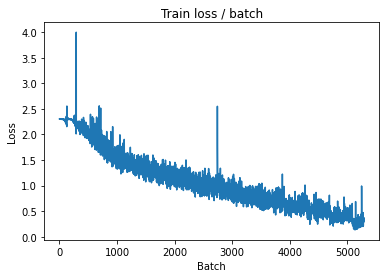


===============> Total time 7s	Avg loss 0.3162	Avg Prec@1 89.01 %	Avg Prec@5 99.81 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 1.3101 (1.3101)	Prec@1  70.3 ( 70.3)	Prec@5  94.5 ( 94.5)

===============> Total time 1s	Avg loss 1.1823	Avg Prec@1 66.54 %	Avg Prec@5 96.65 %



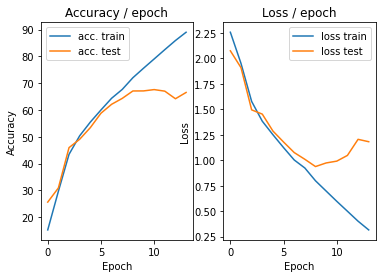

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 0.3284 (0.3284)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


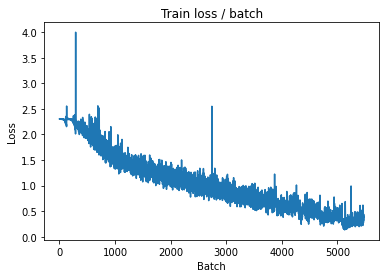

[TRAIN Batch 200/391]	Time 0.030s (0.020s)	Loss 0.1341 (0.2088)	Prec@1  96.9 ( 93.0)	Prec@5 100.0 ( 99.9)



===============> Total time 7s	Avg loss 0.2329	Avg Prec@1 92.02 %	Avg Prec@5 99.91 %

[EVAL Batch 000/079]	Time 0.156s (0.156s)	Loss 1.3870 (1.3870)	Prec@1  71.9 ( 71.9)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.2633	Avg Prec@1 67.57 %	Avg Prec@5 96.83 %



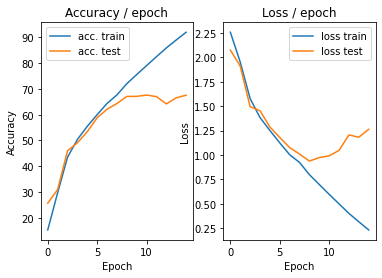

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.157s (0.157s)	Loss 0.1816 (0.1816)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)


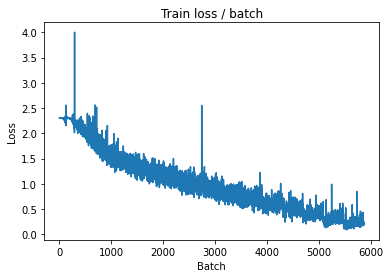

[TRAIN Batch 200/391]	Time 0.039s (0.021s)	Loss 0.0991 (0.1493)	Prec@1  97.7 ( 95.0)	Prec@5 100.0 (100.0)


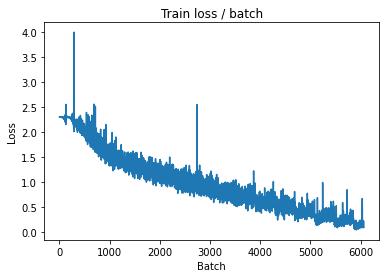


===============> Total time 7s	Avg loss 0.1726	Avg Prec@1 94.11 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 1.3504 (1.3504)	Prec@1  69.5 ( 69.5)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.3219	Avg Prec@1 68.30 %	Avg Prec@5 96.63 %



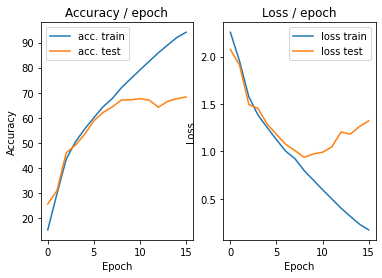

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.146s (0.146s)	Loss 0.1909 (0.1909)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


[TRAIN Batch 200/391]	Time 0.027s (0.019s)	Loss 0.0564 (0.1109)	Prec@1  99.2 ( 96.6)	Prec@5 100.0 (100.0)


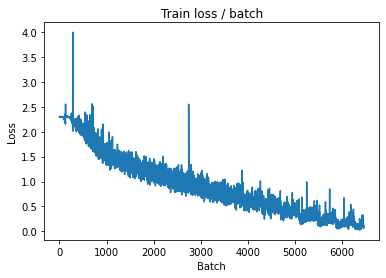


===============> Total time 7s	Avg loss 0.1266	Avg Prec@1 95.82 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 1.6091 (1.6091)	Prec@1  64.1 ( 64.1)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.4912	Avg Prec@1 68.09 %	Avg Prec@5 96.64 %



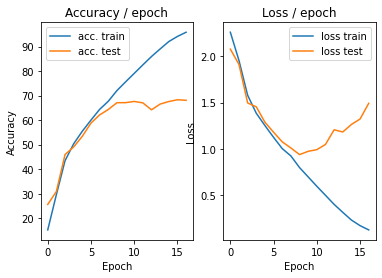

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 0.0891 (0.0891)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


[TRAIN Batch 200/391]	Time 0.012s (0.020s)	Loss 0.1190 (0.0777)	Prec@1  96.1 ( 97.6)	Prec@5 100.0 (100.0)


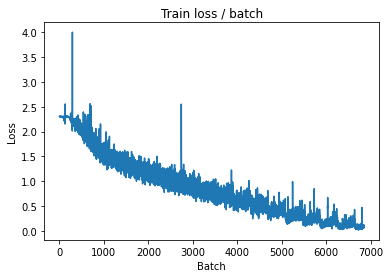


===============> Total time 7s	Avg loss 0.0928	Avg Prec@1 97.01 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 1.9079 (1.9079)	Prec@1  64.1 ( 64.1)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.7766	Avg Prec@1 66.45 %	Avg Prec@5 96.64 %



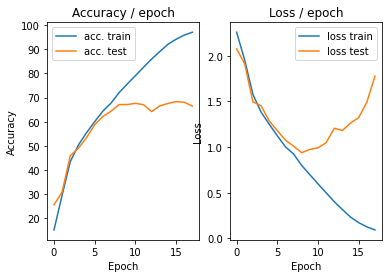

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 0.1334 (0.1334)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


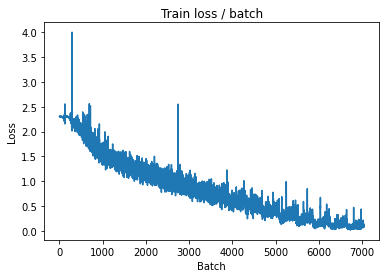

[TRAIN Batch 200/391]	Time 0.013s (0.019s)	Loss 0.0698 (0.0475)	Prec@1  97.7 ( 98.6)	Prec@5 100.0 (100.0)



===============> Total time 7s	Avg loss 0.0679	Avg Prec@1 97.86 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.125s (0.125s)	Loss 1.7226 (1.7226)	Prec@1  69.5 ( 69.5)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.6803	Avg Prec@1 68.53 %	Avg Prec@5 96.63 %



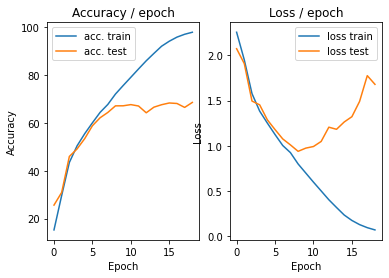

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 0.0873 (0.0873)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


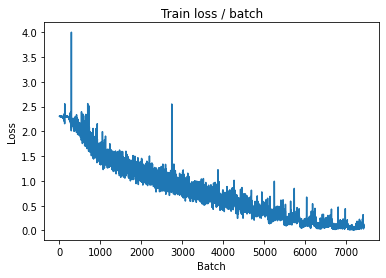

[TRAIN Batch 200/391]	Time 0.019s (0.020s)	Loss 0.0554 (0.0412)	Prec@1  97.7 ( 98.7)	Prec@5 100.0 (100.0)


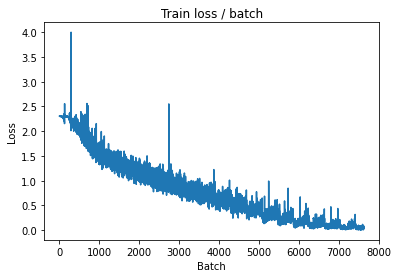


===============> Total time 7s	Avg loss 0.0496	Avg Prec@1 98.48 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 1.7605 (1.7605)	Prec@1  72.7 ( 72.7)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.8419	Avg Prec@1 68.64 %	Avg Prec@5 96.68 %



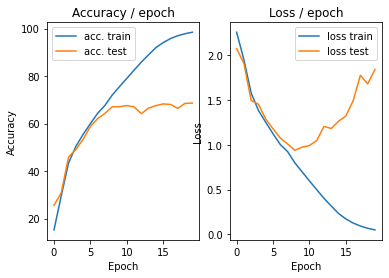

In [12]:
main(128, 0.1, cuda=True, epochs=20)

## Standardization of examples

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.172s (0.172s)	Loss 2.3041 (2.3041)	Prec@1   9.4 (  9.4)	Prec@5  51.6 ( 51.6)


<Figure size 432x288 with 0 Axes>

[TRAIN Batch 200/391]	Time 0.027s (0.029s)	Loss 1.6391 (1.9154)	Prec@1  43.8 ( 30.3)	Prec@5  87.5 ( 80.6)


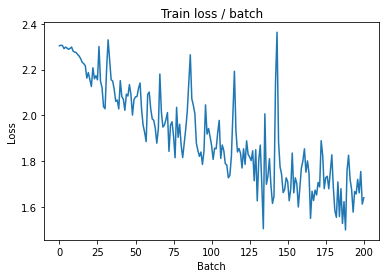


===============> Total time 11s	Avg loss 1.7208	Avg Prec@1 37.52 %	Avg Prec@5 85.85 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 1.3562 (1.3562)	Prec@1  53.9 ( 53.9)	Prec@5  92.2 ( 92.2)

===============> Total time 2s	Avg loss 1.4034	Avg Prec@1 49.59 %	Avg Prec@5 93.80 %



=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.186s (0.186s)	Loss 1.3904 (1.3904)	Prec@1  52.3 ( 52.3)	Prec@5  90.6 ( 90.6)


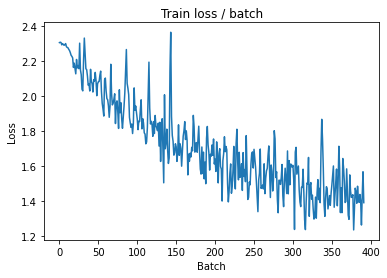

[TRAIN Batch 200/391]	Time 0.008s (0.029s)	Loss 1.1992 (1.3273)	Prec@1  59.4 ( 52.5)	Prec@5  95.3 ( 93.8)



===============> Total time 11s	Avg loss 1.2631	Avg Prec@1 55.24 %	Avg Prec@5 94.51 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 1.1254 (1.1254)	Prec@1  56.2 ( 56.2)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 1.1585	Avg Prec@1 58.56 %	Avg Prec@5 96.19 %



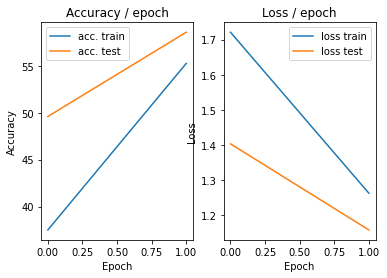

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.166s (0.166s)	Loss 1.0074 (1.0074)	Prec@1  62.5 ( 62.5)	Prec@5  98.4 ( 98.4)


[TRAIN Batch 200/391]	Time 0.019s (0.030s)	Loss 1.0077 (1.0597)	Prec@1  68.8 ( 62.7)	Prec@5  96.1 ( 96.5)



===============> Total time 11s	Avg loss 1.0288	Avg Prec@1 63.91 %	Avg Prec@5 96.61 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 0.9357 (0.9357)	Prec@1  64.8 ( 64.8)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.0093	Avg Prec@1 64.73 %	Avg Prec@5 96.73 %



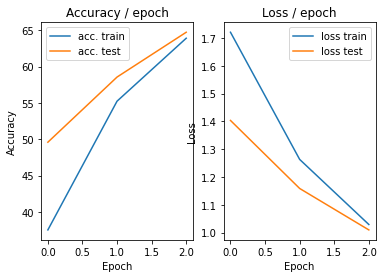

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.172s (0.172s)	Loss 0.8747 (0.8747)	Prec@1  76.6 ( 76.6)	Prec@5  95.3 ( 95.3)


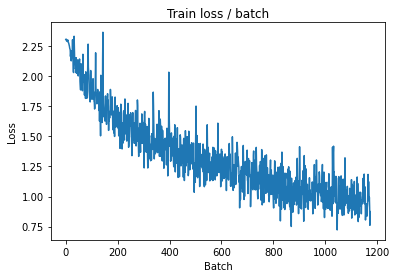

[TRAIN Batch 200/391]	Time 0.038s (0.029s)	Loss 0.8165 (0.8732)	Prec@1  71.1 ( 69.4)	Prec@5  98.4 ( 97.7)



===============> Total time 11s	Avg loss 0.8612	Avg Prec@1 69.92 %	Avg Prec@5 97.70 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 0.8352 (0.8352)	Prec@1  70.3 ( 70.3)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8790	Avg Prec@1 68.89 %	Avg Prec@5 97.55 %



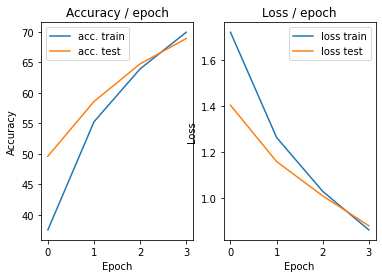

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.164s (0.164s)	Loss 0.6647 (0.6647)	Prec@1  77.3 ( 77.3)	Prec@5  99.2 ( 99.2)


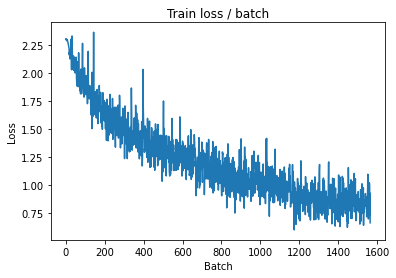

[TRAIN Batch 200/391]	Time 0.015s (0.030s)	Loss 0.7041 (0.7228)	Prec@1  75.0 ( 74.9)	Prec@5 100.0 ( 98.4)


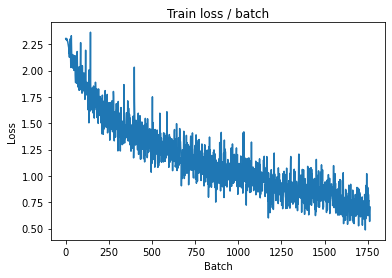


===============> Total time 11s	Avg loss 0.7149	Avg Prec@1 75.03 %	Avg Prec@5 98.49 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 1.0974 (1.0974)	Prec@1  60.2 ( 60.2)	Prec@5  94.5 ( 94.5)

===============> Total time 2s	Avg loss 1.1705	Avg Prec@1 60.92 %	Avg Prec@5 96.20 %



=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.178s (0.178s)	Loss 0.9061 (0.9061)	Prec@1  64.1 ( 64.1)	Prec@5  98.4 ( 98.4)


[TRAIN Batch 200/391]	Time 0.035s (0.029s)	Loss 0.7247 (0.5958)	Prec@1  77.3 ( 78.9)	Prec@5  97.7 ( 99.0)



===============> Total time 11s	Avg loss 0.6009	Avg Prec@1 78.94 %	Avg Prec@5 99.05 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.7087 (0.7087)	Prec@1  75.0 ( 75.0)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.8496	Avg Prec@1 71.09 %	Avg Prec@5 97.94 %



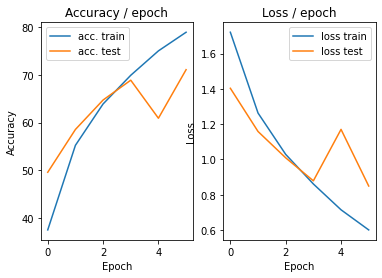

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.174s (0.174s)	Loss 0.4527 (0.4527)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


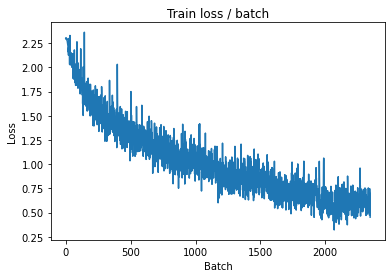

[TRAIN Batch 200/391]	Time 0.015s (0.030s)	Loss 0.4920 (0.4693)	Prec@1  81.2 ( 83.5)	Prec@5 100.0 ( 99.4)


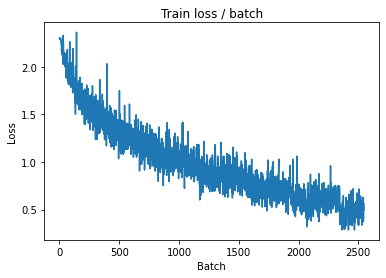


===============> Total time 11s	Avg loss 0.4833	Avg Prec@1 83.02 %	Avg Prec@5 99.39 %

[EVAL Batch 000/079]	Time 0.156s (0.156s)	Loss 0.8374 (0.8374)	Prec@1  72.7 ( 72.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8534	Avg Prec@1 72.17 %	Avg Prec@5 97.76 %



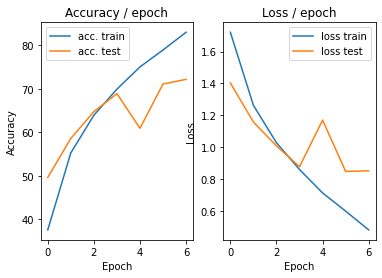

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.162s (0.162s)	Loss 0.4931 (0.4931)	Prec@1  80.5 ( 80.5)	Prec@5 100.0 (100.0)


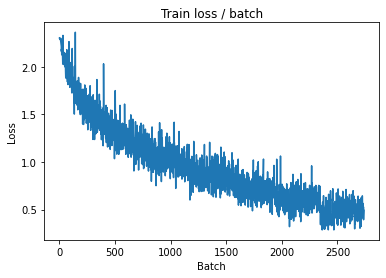

[TRAIN Batch 200/391]	Time 0.044s (0.030s)	Loss 0.4880 (0.3673)	Prec@1  82.8 ( 87.0)	Prec@5 100.0 ( 99.7)


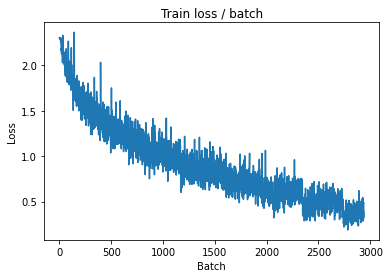


===============> Total time 11s	Avg loss 0.3733	Avg Prec@1 86.95 %	Avg Prec@5 99.70 %

[EVAL Batch 000/079]	Time 0.204s (0.204s)	Loss 1.2582 (1.2582)	Prec@1  64.8 ( 64.8)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.0192	Avg Prec@1 69.32 %	Avg Prec@5 97.52 %



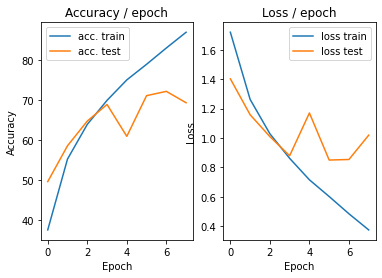

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 0.4644 (0.4644)	Prec@1  82.0 ( 82.0)	Prec@5 100.0 (100.0)


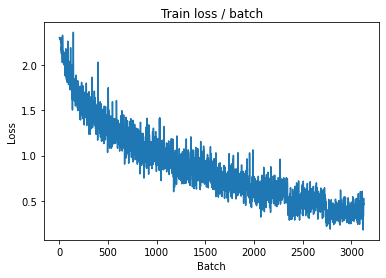

[TRAIN Batch 200/391]	Time 0.015s (0.034s)	Loss 0.2094 (0.2568)	Prec@1  94.5 ( 91.5)	Prec@5 100.0 ( 99.8)


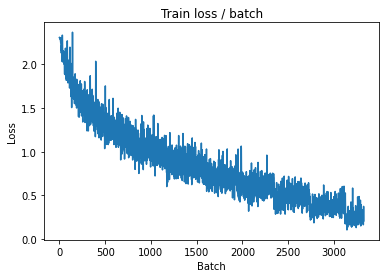


===============> Total time 12s	Avg loss 0.2757	Avg Prec@1 90.58 %	Avg Prec@5 99.85 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 1.1298 (1.1298)	Prec@1  68.8 ( 68.8)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.9585	Avg Prec@1 72.98 %	Avg Prec@5 97.98 %



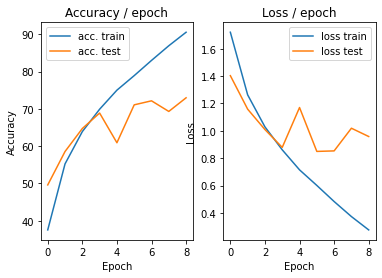

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.180s (0.180s)	Loss 0.2467 (0.2467)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


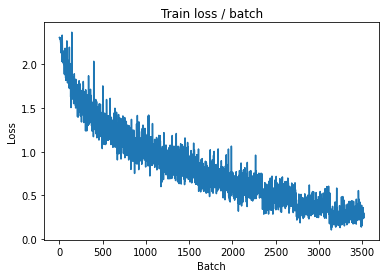

[TRAIN Batch 200/391]	Time 0.015s (0.029s)	Loss 0.1937 (0.1819)	Prec@1  94.5 ( 93.7)	Prec@5 100.0 (100.0)


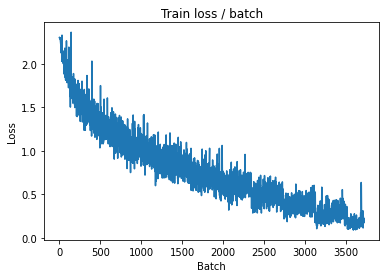


===============> Total time 11s	Avg loss 0.1964	Avg Prec@1 93.14 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.9741 (0.9741)	Prec@1  75.0 ( 75.0)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0073	Avg Prec@1 73.99 %	Avg Prec@5 97.79 %



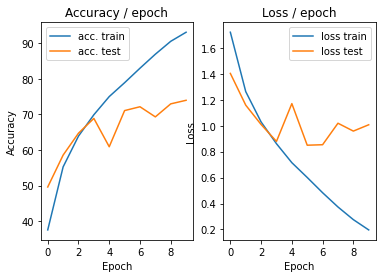

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.177s (0.177s)	Loss 0.0984 (0.0984)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


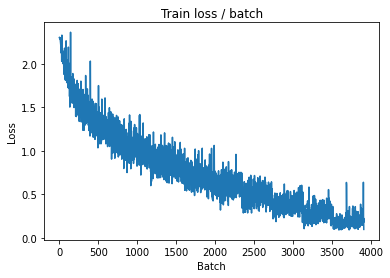

[TRAIN Batch 200/391]	Time 0.018s (0.029s)	Loss 0.3504 (0.1314)	Prec@1  87.5 ( 95.7)	Prec@5  99.2 (100.0)


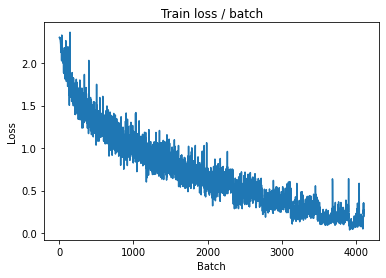


===============> Total time 12s	Avg loss 0.1519	Avg Prec@1 94.88 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.166s (0.166s)	Loss 1.0973 (1.0973)	Prec@1  76.6 ( 76.6)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.1155	Avg Prec@1 73.21 %	Avg Prec@5 97.68 %



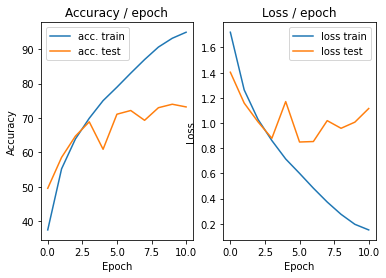

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.171s (0.171s)	Loss 0.0684 (0.0684)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


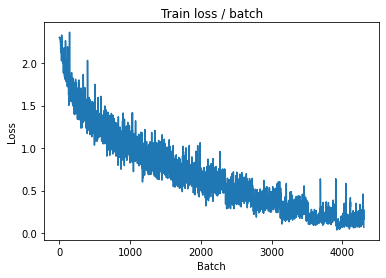

[TRAIN Batch 200/391]	Time 0.018s (0.029s)	Loss 0.0607 (0.0812)	Prec@1  97.7 ( 97.3)	Prec@5 100.0 (100.0)


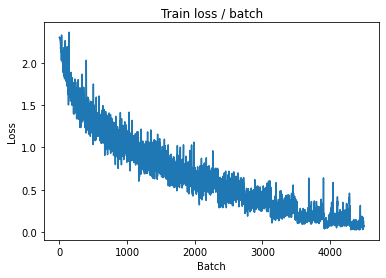


===============> Total time 11s	Avg loss 0.1128	Avg Prec@1 96.22 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 1.3655 (1.3655)	Prec@1  73.4 ( 73.4)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.2933	Avg Prec@1 72.84 %	Avg Prec@5 97.50 %



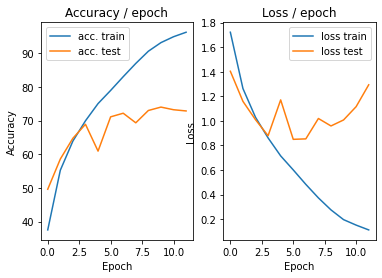

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.168s (0.168s)	Loss 0.0806 (0.0806)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


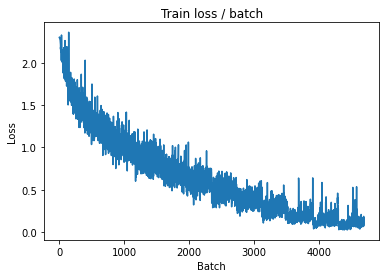

[TRAIN Batch 200/391]	Time 0.041s (0.029s)	Loss 0.0755 (0.0541)	Prec@1  97.7 ( 98.3)	Prec@5 100.0 (100.0)


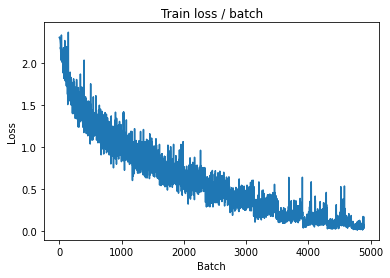


===============> Total time 11s	Avg loss 0.0777	Avg Prec@1 97.44 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 1.4399 (1.4399)	Prec@1  69.5 ( 69.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 1.3330	Avg Prec@1 72.86 %	Avg Prec@5 97.61 %



=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.177s (0.177s)	Loss 0.0531 (0.0531)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


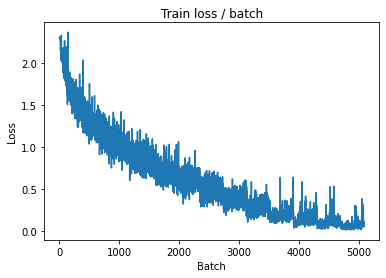

[TRAIN Batch 200/391]	Time 0.024s (0.029s)	Loss 0.1352 (0.0423)	Prec@1  94.5 ( 98.7)	Prec@5 100.0 (100.0)


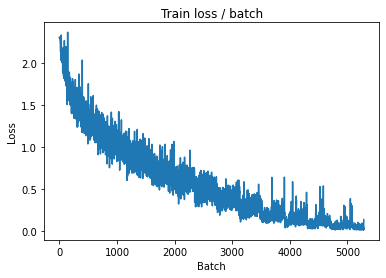


===============> Total time 12s	Avg loss 0.0614	Avg Prec@1 97.96 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 1.4591 (1.4591)	Prec@1  75.8 ( 75.8)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.3414	Avg Prec@1 73.20 %	Avg Prec@5 97.59 %



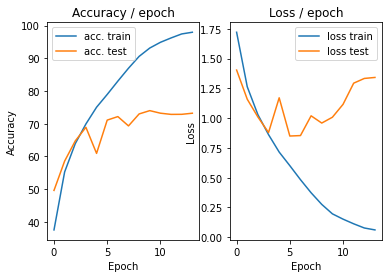

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.0812 (0.0812)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


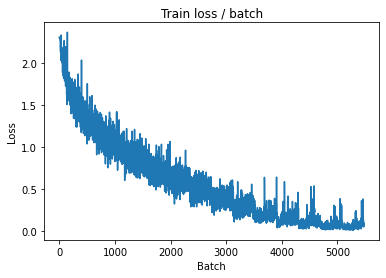

[TRAIN Batch 200/391]	Time 0.024s (0.031s)	Loss 0.1002 (0.0449)	Prec@1  96.1 ( 98.7)	Prec@5 100.0 (100.0)


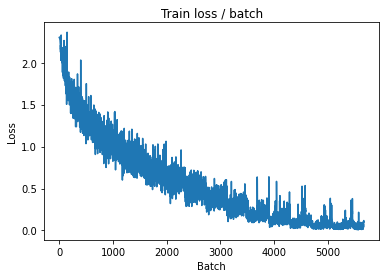


===============> Total time 11s	Avg loss 0.0578	Avg Prec@1 98.18 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 1.6742 (1.6742)	Prec@1  71.1 ( 71.1)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.5999	Avg Prec@1 72.44 %	Avg Prec@5 97.60 %



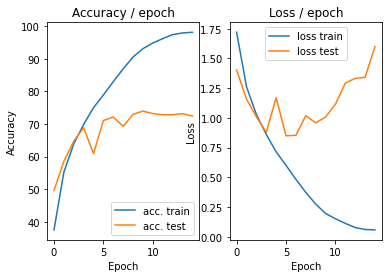

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.0826 (0.0826)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


[TRAIN Batch 200/391]	Time 0.048s (0.029s)	Loss 0.0669 (0.0414)	Prec@1  98.4 ( 98.8)	Prec@5 100.0 (100.0)


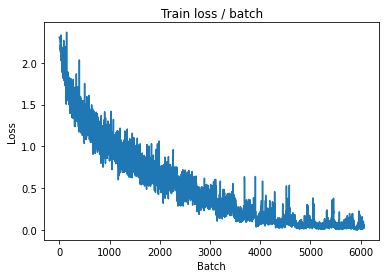


===============> Total time 11s	Avg loss 0.0542	Avg Prec@1 98.30 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 1.5939 (1.5939)	Prec@1  72.7 ( 72.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.6030	Avg Prec@1 72.20 %	Avg Prec@5 97.57 %



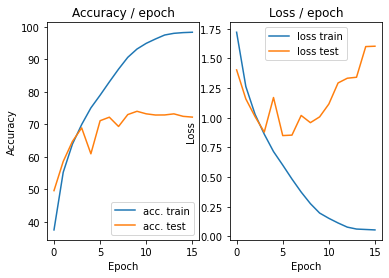

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.179s (0.179s)	Loss 0.0360 (0.0360)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


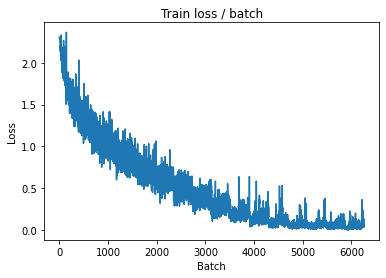

[TRAIN Batch 200/391]	Time 0.010s (0.029s)	Loss 0.0173 (0.0356)	Prec@1 100.0 ( 98.9)	Prec@5 100.0 (100.0)


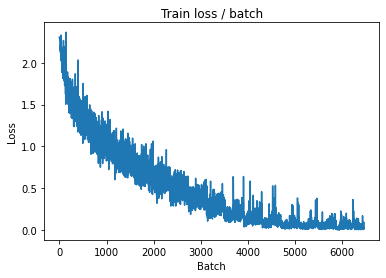


===============> Total time 12s	Avg loss 0.0500	Avg Prec@1 98.42 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.155s (0.155s)	Loss 1.6567 (1.6567)	Prec@1  74.2 ( 74.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.5500	Avg Prec@1 73.64 %	Avg Prec@5 97.68 %



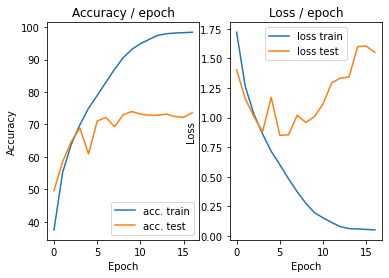

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.176s (0.176s)	Loss 0.0221 (0.0221)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


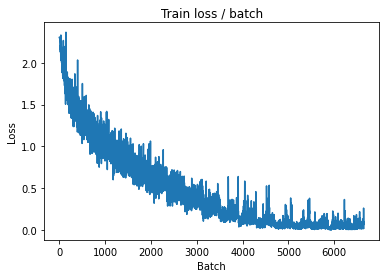

[TRAIN Batch 200/391]	Time 0.030s (0.029s)	Loss 0.0313 (0.0299)	Prec@1  99.2 ( 99.1)	Prec@5 100.0 (100.0)


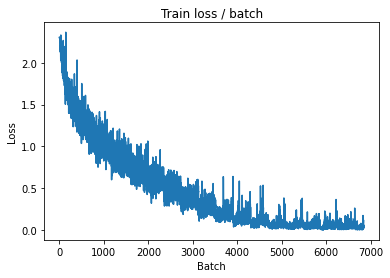


===============> Total time 11s	Avg loss 0.0370	Avg Prec@1 98.84 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 1.6969 (1.6969)	Prec@1  72.7 ( 72.7)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.5421	Avg Prec@1 74.58 %	Avg Prec@5 97.61 %



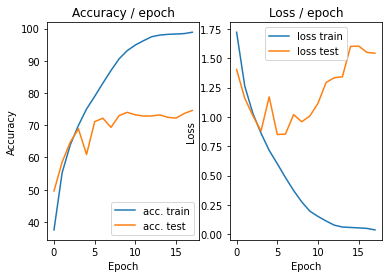

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.188s (0.188s)	Loss 0.0155 (0.0155)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


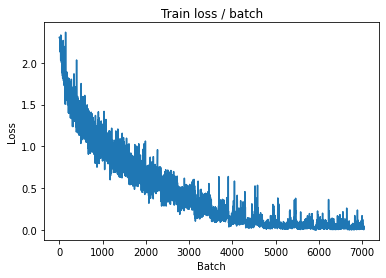

[TRAIN Batch 200/391]	Time 0.017s (0.030s)	Loss 0.0315 (0.0203)	Prec@1  99.2 ( 99.4)	Prec@5 100.0 (100.0)


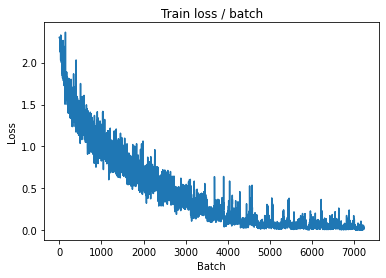


===============> Total time 11s	Avg loss 0.0221	Avg Prec@1 99.35 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.183s (0.183s)	Loss 1.7435 (1.7435)	Prec@1  75.0 ( 75.0)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.6752	Avg Prec@1 74.59 %	Avg Prec@5 97.80 %



=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.182s (0.182s)	Loss 0.0036 (0.0036)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


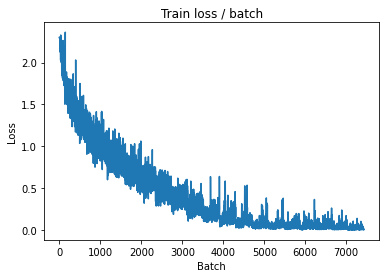

[TRAIN Batch 200/391]	Time 0.076s (0.030s)	Loss 0.0075 (0.0170)	Prec@1 100.0 ( 99.5)	Prec@5 100.0 (100.0)


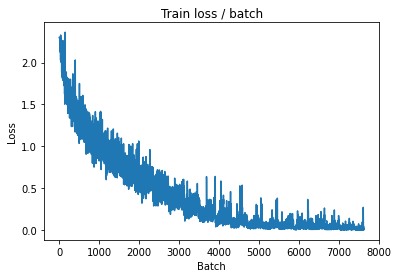


===============> Total time 12s	Avg loss 0.0191	Avg Prec@1 99.45 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 2.0393 (2.0393)	Prec@1  71.9 ( 71.9)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.8082	Avg Prec@1 73.72 %	Avg Prec@5 97.58 %



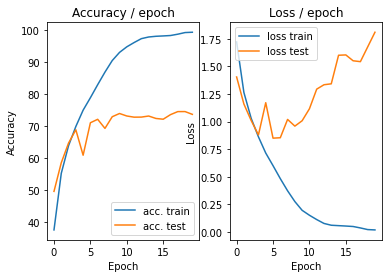

In [13]:
def get_dataset(batch_size, cuda=False, transform_means=[0.491, 0.482, 0.447], transform_std=[0.202, 0.199, 0.201]):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=transform_means, std=transform_std)
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=transform_means, std=transform_std)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

main(128, 0.1, cuda=True, epochs=20)

## Data increase

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.289s (0.289s)	Loss 2.3023 (2.3023)	Prec@1  16.4 ( 16.4)	Prec@5  50.0 ( 50.0)


<Figure size 432x288 with 0 Axes>

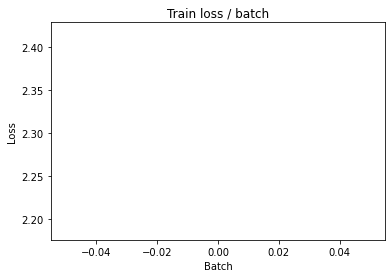

[TRAIN Batch 200/391]	Time 0.044s (0.042s)	Loss 1.6270 (1.9915)	Prec@1  45.3 ( 26.9)	Prec@5  90.6 ( 77.7)


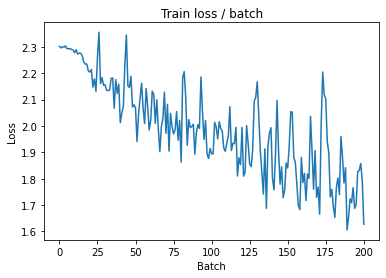


===============> Total time 15s	Avg loss 1.8210	Avg Prec@1 33.53 %	Avg Prec@5 83.28 %

[EVAL Batch 000/079]	Time 0.175s (0.175s)	Loss 1.5044 (1.5044)	Prec@1  51.6 ( 51.6)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.4827	Avg Prec@1 46.68 %	Avg Prec@5 92.28 %



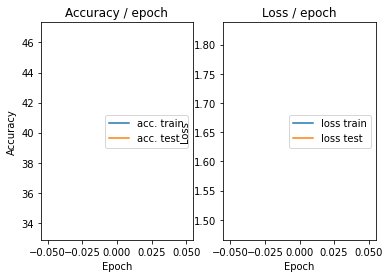

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 1.6484 (1.6484)	Prec@1  37.5 ( 37.5)	Prec@5  87.5 ( 87.5)


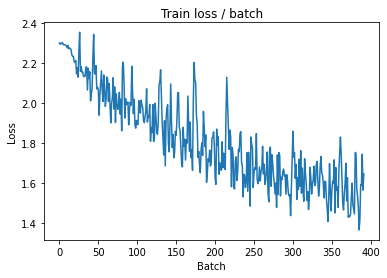

[TRAIN Batch 200/391]	Time 0.065s (0.039s)	Loss 1.4518 (1.4654)	Prec@1  50.8 ( 47.2)	Prec@5  93.0 ( 92.3)


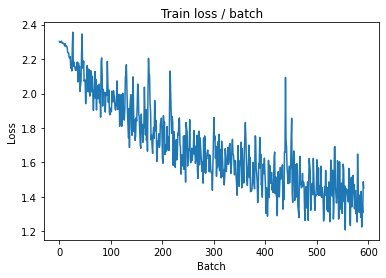


===============> Total time 14s	Avg loss 1.4016	Avg Prec@1 49.96 %	Avg Prec@5 92.99 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 1.2592 (1.2592)	Prec@1  57.8 ( 57.8)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.2780	Avg Prec@1 54.81 %	Avg Prec@5 94.43 %



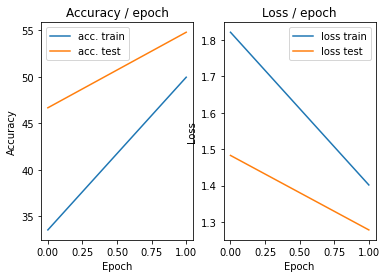

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.190s (0.190s)	Loss 1.2670 (1.2670)	Prec@1  53.1 ( 53.1)	Prec@5  97.7 ( 97.7)


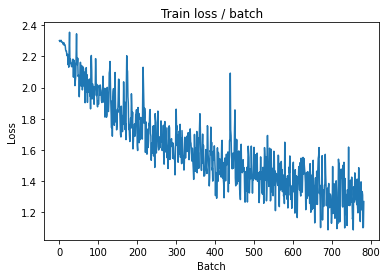

[TRAIN Batch 200/391]	Time 0.054s (0.038s)	Loss 1.3780 (1.2347)	Prec@1  51.6 ( 56.5)	Prec@5  90.6 ( 94.8)


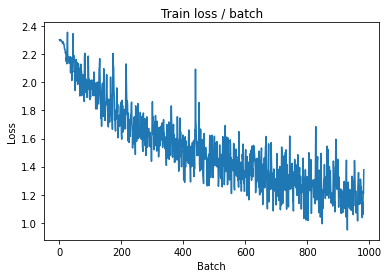


===============> Total time 15s	Avg loss 1.1865	Avg Prec@1 58.40 %	Avg Prec@5 95.20 %

[EVAL Batch 000/079]	Time 0.182s (0.182s)	Loss 1.0496 (1.0496)	Prec@1  61.7 ( 61.7)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0806	Avg Prec@1 61.83 %	Avg Prec@5 96.09 %



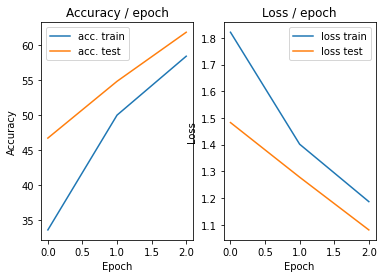

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.186s (0.186s)	Loss 0.9344 (0.9344)	Prec@1  71.9 ( 71.9)	Prec@5  97.7 ( 97.7)


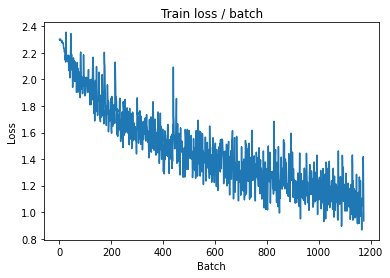

[TRAIN Batch 200/391]	Time 0.016s (0.038s)	Loss 0.9462 (1.0597)	Prec@1  68.8 ( 63.1)	Prec@5  99.2 ( 96.2)


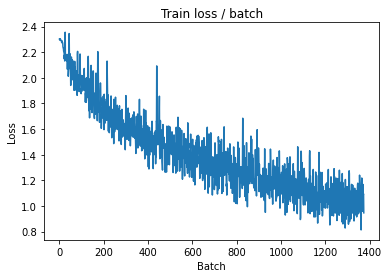


===============> Total time 14s	Avg loss 1.0273	Avg Prec@1 64.25 %	Avg Prec@5 96.53 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 1.0020 (1.0020)	Prec@1  64.1 ( 64.1)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.0192	Avg Prec@1 65.37 %	Avg Prec@5 95.94 %



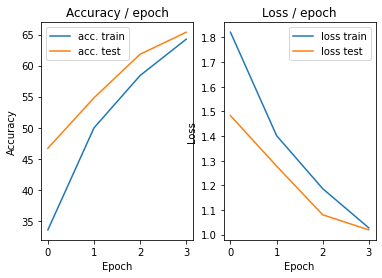

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.177s (0.177s)	Loss 1.0254 (1.0254)	Prec@1  65.6 ( 65.6)	Prec@5  94.5 ( 94.5)


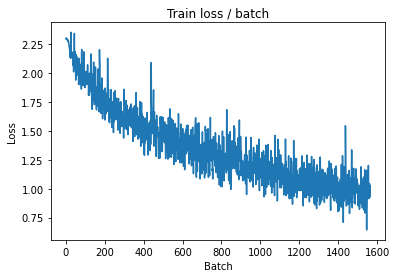

[TRAIN Batch 200/391]	Time 0.048s (0.037s)	Loss 1.1039 (0.9374)	Prec@1  66.4 ( 67.0)	Prec@5  95.3 ( 97.2)


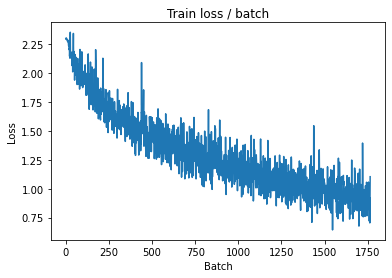


===============> Total time 14s	Avg loss 0.9167	Avg Prec@1 67.99 %	Avg Prec@5 97.28 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.8371 (0.8371)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 0.9081	Avg Prec@1 68.47 %	Avg Prec@5 97.31 %



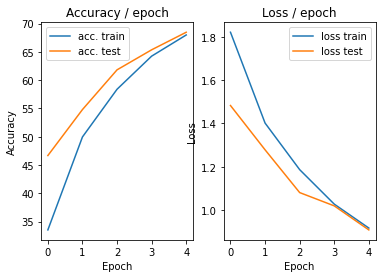

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 0.9854 (0.9854)	Prec@1  60.9 ( 60.9)	Prec@5  95.3 ( 95.3)


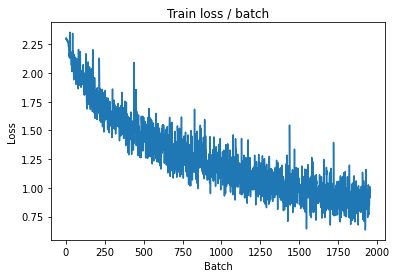

[TRAIN Batch 200/391]	Time 0.070s (0.038s)	Loss 0.8049 (0.8422)	Prec@1  68.0 ( 70.7)	Prec@5  97.7 ( 97.7)


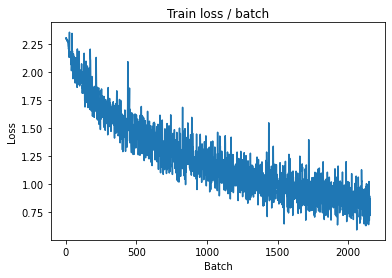


===============> Total time 14s	Avg loss 0.8304	Avg Prec@1 71.06 %	Avg Prec@5 97.82 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 1.0112 (1.0112)	Prec@1  68.0 ( 68.0)	Prec@5  94.5 ( 94.5)

===============> Total time 2s	Avg loss 1.0071	Avg Prec@1 67.33 %	Avg Prec@5 95.98 %



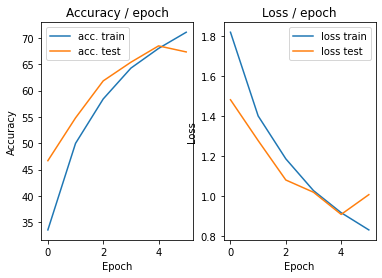

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.205s (0.205s)	Loss 1.1261 (1.1261)	Prec@1  68.0 ( 68.0)	Prec@5  95.3 ( 95.3)


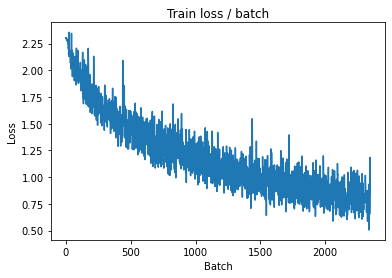

[TRAIN Batch 200/391]	Time 0.008s (0.038s)	Loss 0.6638 (0.7799)	Prec@1  79.7 ( 73.3)	Prec@5  97.7 ( 98.1)


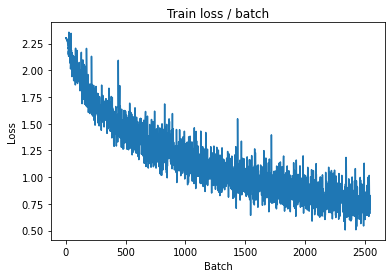


===============> Total time 14s	Avg loss 0.7701	Avg Prec@1 73.47 %	Avg Prec@5 98.13 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 0.9417 (0.9417)	Prec@1  67.2 ( 67.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8525	Avg Prec@1 70.56 %	Avg Prec@5 97.81 %



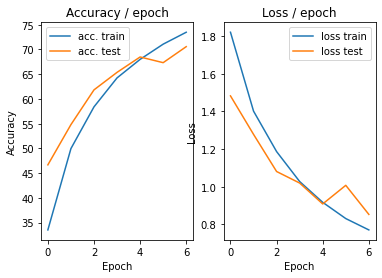

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.199s (0.199s)	Loss 0.6601 (0.6601)	Prec@1  79.7 ( 79.7)	Prec@5  98.4 ( 98.4)


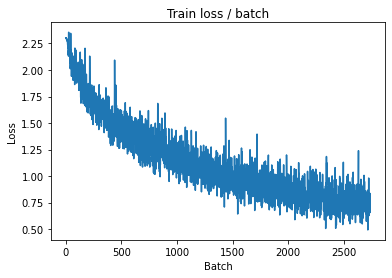

[TRAIN Batch 200/391]	Time 0.018s (0.043s)	Loss 0.8422 (0.7182)	Prec@1  68.8 ( 75.2)	Prec@5  95.3 ( 98.3)


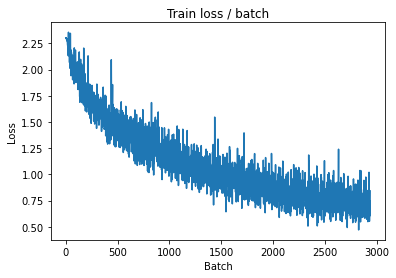


===============> Total time 15s	Avg loss 0.7137	Avg Prec@1 75.22 %	Avg Prec@5 98.34 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 0.7762 (0.7762)	Prec@1  75.0 ( 75.0)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7701	Avg Prec@1 73.52 %	Avg Prec@5 98.05 %



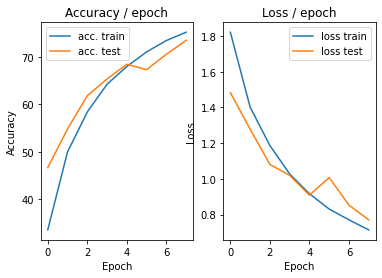

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.200s (0.200s)	Loss 0.5966 (0.5966)	Prec@1  82.0 ( 82.0)	Prec@5  99.2 ( 99.2)


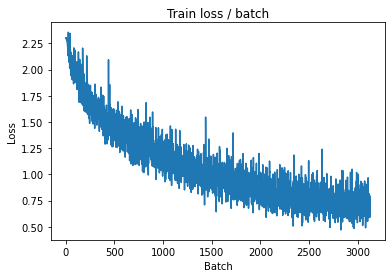

[TRAIN Batch 200/391]	Time 0.060s (0.041s)	Loss 0.6032 (0.6699)	Prec@1  80.5 ( 76.5)	Prec@5  99.2 ( 98.6)


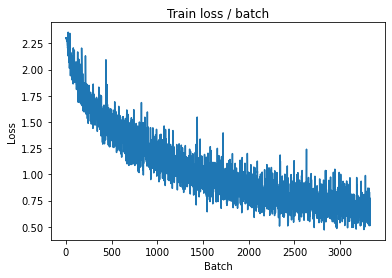


===============> Total time 15s	Avg loss 0.6698	Avg Prec@1 76.55 %	Avg Prec@5 98.59 %

[EVAL Batch 000/079]	Time 0.173s (0.173s)	Loss 0.8390 (0.8390)	Prec@1  70.3 ( 70.3)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.8179	Avg Prec@1 71.02 %	Avg Prec@5 97.77 %



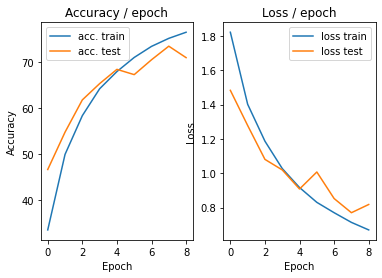

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 0.8325 (0.8325)	Prec@1  68.8 ( 68.8)	Prec@5  97.7 ( 97.7)


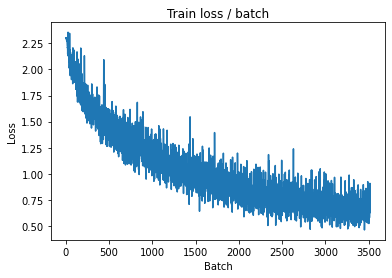

[TRAIN Batch 200/391]	Time 0.081s (0.039s)	Loss 0.6809 (0.6143)	Prec@1  74.2 ( 78.7)	Prec@5  98.4 ( 98.9)


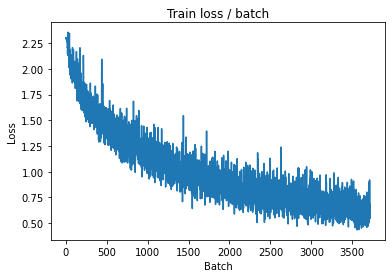


===============> Total time 15s	Avg loss 0.6259	Avg Prec@1 78.32 %	Avg Prec@5 98.78 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 0.6893 (0.6893)	Prec@1  77.3 ( 77.3)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6883	Avg Prec@1 76.53 %	Avg Prec@5 98.42 %



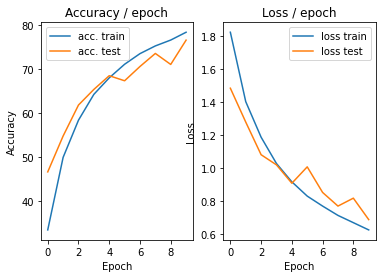

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 0.6022 (0.6022)	Prec@1  78.9 ( 78.9)	Prec@5  99.2 ( 99.2)


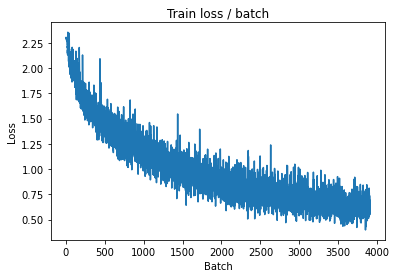

[TRAIN Batch 200/391]	Time 0.011s (0.037s)	Loss 0.5540 (0.5946)	Prec@1  80.5 ( 79.3)	Prec@5  99.2 ( 99.0)


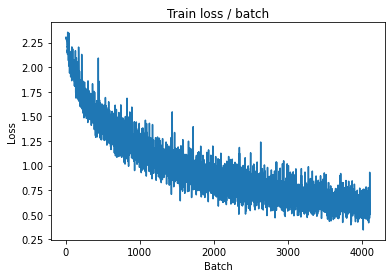


===============> Total time 14s	Avg loss 0.5887	Avg Prec@1 79.60 %	Avg Prec@5 99.01 %

[EVAL Batch 000/079]	Time 0.155s (0.155s)	Loss 0.7545 (0.7545)	Prec@1  78.9 ( 78.9)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.7167	Avg Prec@1 76.06 %	Avg Prec@5 98.33 %



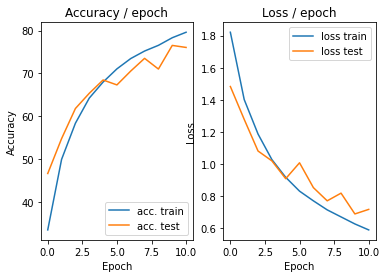

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.196s (0.196s)	Loss 0.5208 (0.5208)	Prec@1  80.5 ( 80.5)	Prec@5 100.0 (100.0)


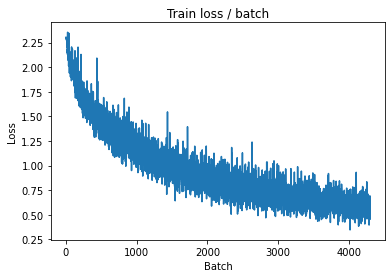

[TRAIN Batch 200/391]	Time 0.009s (0.038s)	Loss 0.5096 (0.5556)	Prec@1  80.5 ( 80.4)	Prec@5  98.4 ( 99.1)


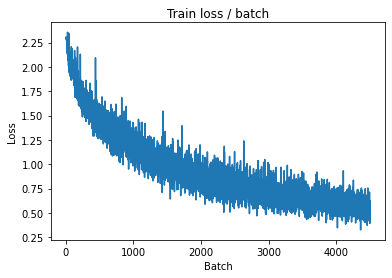


===============> Total time 14s	Avg loss 0.5583	Avg Prec@1 80.50 %	Avg Prec@5 99.06 %

[EVAL Batch 000/079]	Time 0.298s (0.298s)	Loss 0.6715 (0.6715)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6677	Avg Prec@1 77.33 %	Avg Prec@5 98.39 %



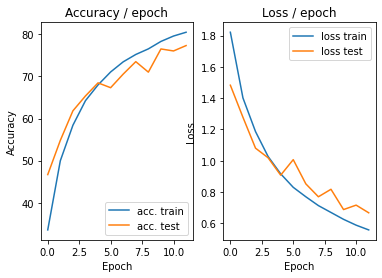

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 0.4400 (0.4400)	Prec@1  87.5 ( 87.5)	Prec@5  98.4 ( 98.4)


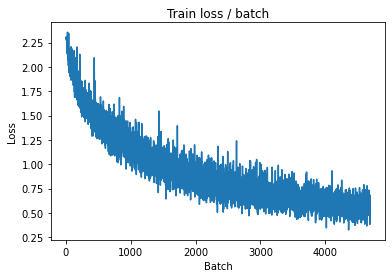

[TRAIN Batch 200/391]	Time 0.047s (0.038s)	Loss 0.4190 (0.5330)	Prec@1  86.7 ( 81.5)	Prec@5 100.0 ( 99.1)


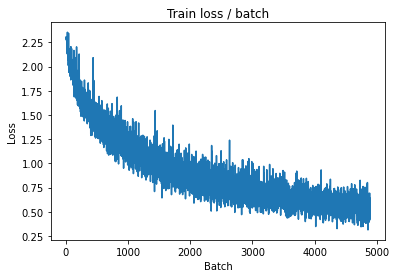


===============> Total time 14s	Avg loss 0.5314	Avg Prec@1 81.51 %	Avg Prec@5 99.13 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 0.6496 (0.6496)	Prec@1  81.2 ( 81.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.7083	Avg Prec@1 76.34 %	Avg Prec@5 98.48 %



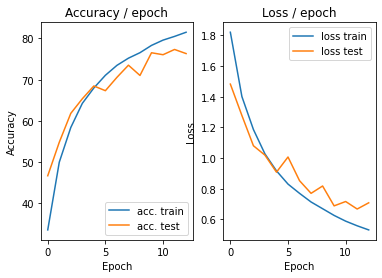

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 0.6076 (0.6076)	Prec@1  80.5 ( 80.5)	Prec@5  97.7 ( 97.7)


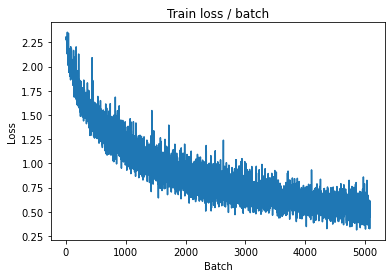

[TRAIN Batch 200/391]	Time 0.063s (0.039s)	Loss 0.5513 (0.4972)	Prec@1  83.6 ( 82.7)	Prec@5 100.0 ( 99.3)


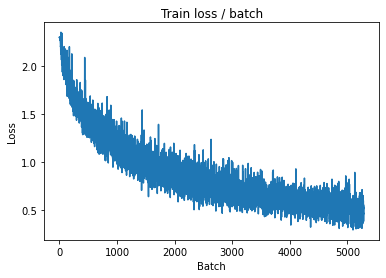


===============> Total time 15s	Avg loss 0.5033	Avg Prec@1 82.53 %	Avg Prec@5 99.21 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 0.6217 (0.6217)	Prec@1  78.9 ( 78.9)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6697	Avg Prec@1 77.89 %	Avg Prec@5 98.40 %



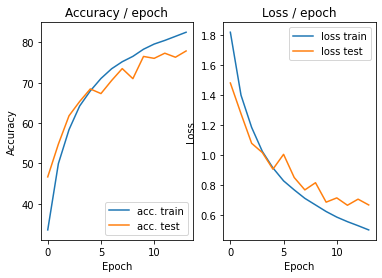

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.5542 (0.5542)	Prec@1  78.1 ( 78.1)	Prec@5 100.0 (100.0)


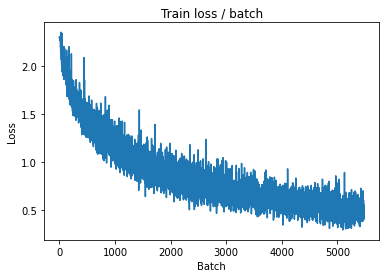

[TRAIN Batch 200/391]	Time 0.014s (0.038s)	Loss 0.4692 (0.4716)	Prec@1  81.2 ( 83.3)	Prec@5  99.2 ( 99.4)


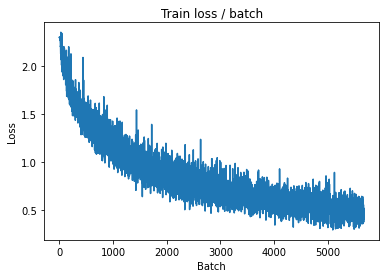


===============> Total time 14s	Avg loss 0.4781	Avg Prec@1 83.20 %	Avg Prec@5 99.38 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 0.5788 (0.5788)	Prec@1  80.5 ( 80.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6453	Avg Prec@1 78.64 %	Avg Prec@5 98.66 %



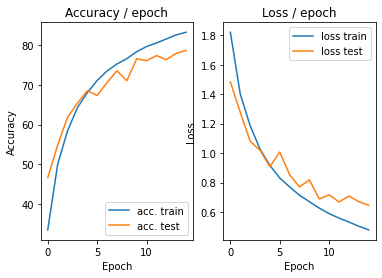

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.214s (0.214s)	Loss 0.3882 (0.3882)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)


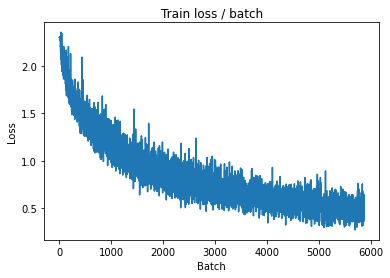

[TRAIN Batch 200/391]	Time 0.015s (0.037s)	Loss 0.5489 (0.4505)	Prec@1  83.6 ( 84.1)	Prec@5  98.4 ( 99.4)


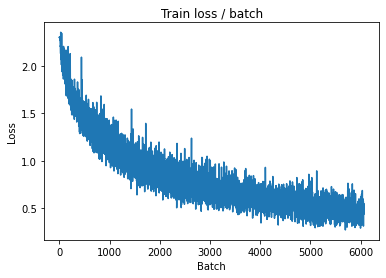


===============> Total time 14s	Avg loss 0.4573	Avg Prec@1 83.82 %	Avg Prec@5 99.40 %

[EVAL Batch 000/079]	Time 0.175s (0.175s)	Loss 0.5350 (0.5350)	Prec@1  81.2 ( 81.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6253	Avg Prec@1 79.01 %	Avg Prec@5 98.82 %



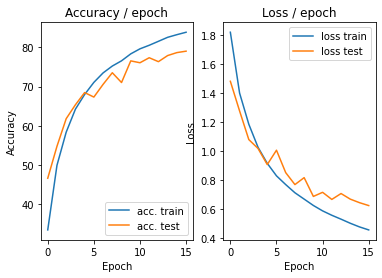

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.213s (0.213s)	Loss 0.4333 (0.4333)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)


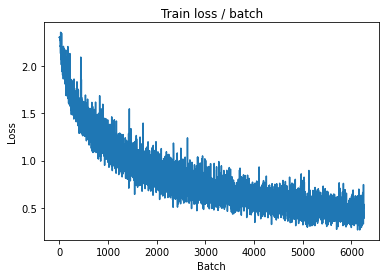

[TRAIN Batch 200/391]	Time 0.057s (0.043s)	Loss 0.4953 (0.4323)	Prec@1  82.8 ( 84.9)	Prec@5  97.7 ( 99.4)


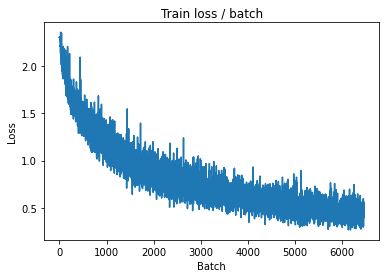


===============> Total time 15s	Avg loss 0.4419	Avg Prec@1 84.53 %	Avg Prec@5 99.45 %

[EVAL Batch 000/079]	Time 0.175s (0.175s)	Loss 0.6563 (0.6563)	Prec@1  82.0 ( 82.0)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7204	Avg Prec@1 76.76 %	Avg Prec@5 98.26 %



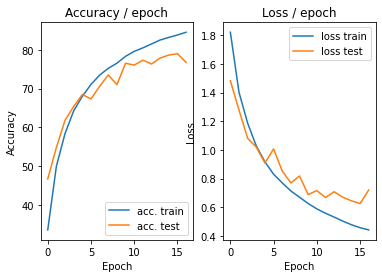

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.211s (0.211s)	Loss 0.5093 (0.5093)	Prec@1  85.9 ( 85.9)	Prec@5  98.4 ( 98.4)


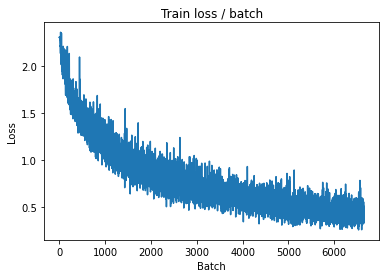

[TRAIN Batch 200/391]	Time 0.017s (0.039s)	Loss 0.3134 (0.4131)	Prec@1  89.8 ( 85.7)	Prec@5 100.0 ( 99.6)


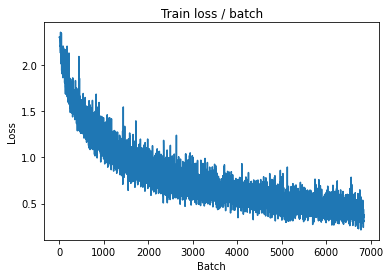


===============> Total time 15s	Avg loss 0.4166	Avg Prec@1 85.46 %	Avg Prec@5 99.56 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.8252 (0.8252)	Prec@1  79.7 ( 79.7)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.7640	Avg Prec@1 75.94 %	Avg Prec@5 98.08 %



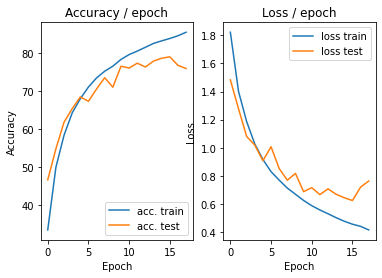

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.208s (0.208s)	Loss 0.5140 (0.5140)	Prec@1  82.0 ( 82.0)	Prec@5  98.4 ( 98.4)


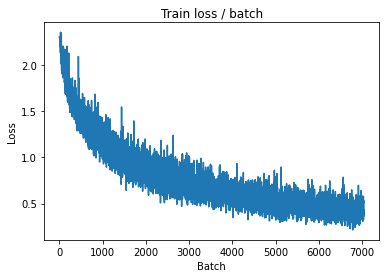

[TRAIN Batch 200/391]	Time 0.057s (0.043s)	Loss 0.4256 (0.3896)	Prec@1  89.1 ( 86.5)	Prec@5 100.0 ( 99.6)


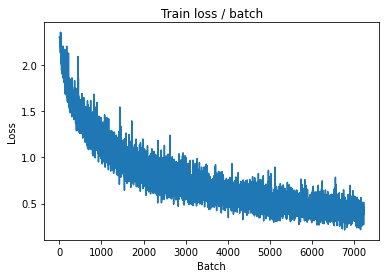


===============> Total time 15s	Avg loss 0.4009	Avg Prec@1 86.01 %	Avg Prec@5 99.56 %

[EVAL Batch 000/079]	Time 0.155s (0.155s)	Loss 0.5692 (0.5692)	Prec@1  80.5 ( 80.5)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.6600	Avg Prec@1 79.08 %	Avg Prec@5 98.53 %



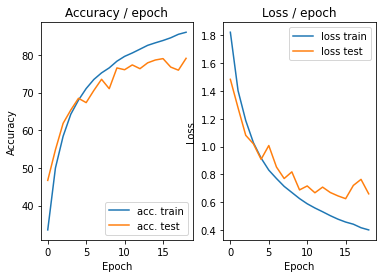

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.216s (0.216s)	Loss 0.3277 (0.3277)	Prec@1  91.4 ( 91.4)	Prec@5  99.2 ( 99.2)


[TRAIN Batch 200/391]	Time 0.049s (0.038s)	Loss 0.3719 (0.3717)	Prec@1  89.1 ( 87.3)	Prec@5 100.0 ( 99.7)


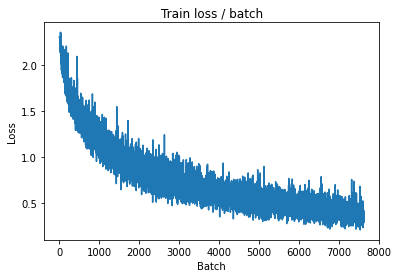


===============> Total time 14s	Avg loss 0.3806	Avg Prec@1 86.98 %	Avg Prec@5 99.63 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 0.5607 (0.5607)	Prec@1  79.7 ( 79.7)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6457	Avg Prec@1 80.11 %	Avg Prec@5 98.47 %



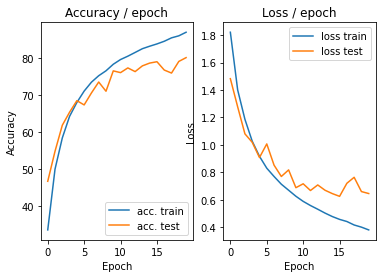

In [14]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output


def get_dataset(batch_size, cuda=False, transform_means=[0.491, 0.482, 0.447], transform_std=[0.202, 0.199, 0.201]):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=28),
            transforms.Normalize(mean=transform_means, std=transform_std)
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(size=28),
            transforms.Normalize(mean=transform_means, std=transform_std)
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

main(128, 0.1, cuda=True, epochs=20)

## Optimization algo

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.180s (0.180s)	Loss 2.3013 (2.3013)	Prec@1  13.3 ( 13.3)	Prec@5  53.1 ( 53.1)


<Figure size 432x288 with 0 Axes>

[TRAIN Batch 200/391]	Time 0.053s (0.037s)	Loss 2.0702 (1.9760)	Prec@1  28.1 ( 28.2)	Prec@5  81.2 ( 77.9)



===============> Total time 14s	Avg loss 1.8057	Avg Prec@1 34.57 %	Avg Prec@5 83.55 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 1.5832 (1.5832)	Prec@1  47.7 ( 47.7)	Prec@5  89.8 ( 89.8)

===============> Total time 2s	Avg loss 1.5886	Avg Prec@1 42.60 %	Avg Prec@5 91.27 %



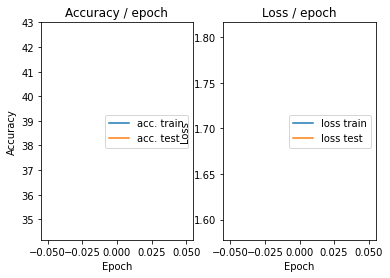

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 1.6522 (1.6522)	Prec@1  35.2 ( 35.2)	Prec@5  95.3 ( 95.3)


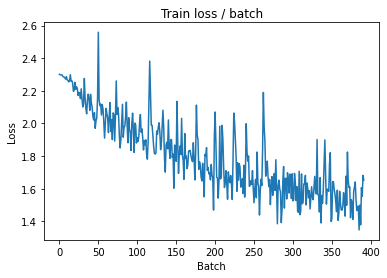

[TRAIN Batch 200/391]	Time 0.013s (0.041s)	Loss 1.2105 (1.4376)	Prec@1  57.0 ( 48.4)	Prec@5  96.9 ( 92.6)


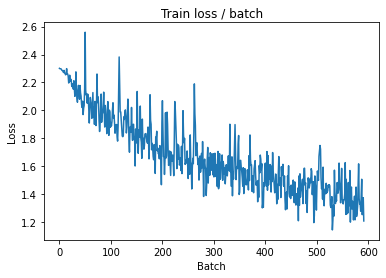


===============> Total time 16s	Avg loss 1.3814	Avg Prec@1 50.76 %	Avg Prec@5 93.22 %

[EVAL Batch 000/079]	Time 0.190s (0.190s)	Loss 1.2968 (1.2968)	Prec@1  56.2 ( 56.2)	Prec@5  93.0 ( 93.0)

===============> Total time 2s	Avg loss 1.3161	Avg Prec@1 54.25 %	Avg Prec@5 94.25 %



=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.204s (0.204s)	Loss 1.5569 (1.5569)	Prec@1  49.2 ( 49.2)	Prec@5  91.4 ( 91.4)


[TRAIN Batch 200/391]	Time 0.064s (0.038s)	Loss 1.1219 (1.2108)	Prec@1  59.4 ( 57.3)	Prec@5  96.1 ( 95.1)


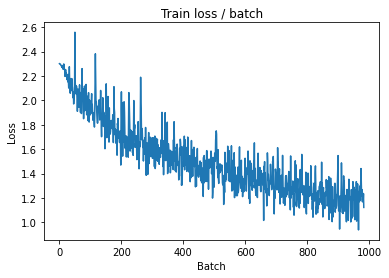


===============> Total time 14s	Avg loss 1.1709	Avg Prec@1 58.95 %	Avg Prec@5 95.33 %

[EVAL Batch 000/079]	Time 0.174s (0.174s)	Loss 0.9652 (0.9652)	Prec@1  67.2 ( 67.2)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0265	Avg Prec@1 64.18 %	Avg Prec@5 96.58 %



=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.172s (0.172s)	Loss 0.9740 (0.9740)	Prec@1  70.3 ( 70.3)	Prec@5  98.4 ( 98.4)


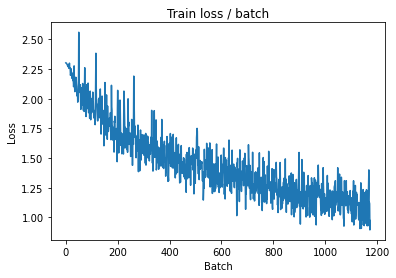

[TRAIN Batch 200/391]	Time 0.047s (0.038s)	Loss 1.0041 (1.0313)	Prec@1  57.8 ( 64.0)	Prec@5  96.1 ( 96.7)


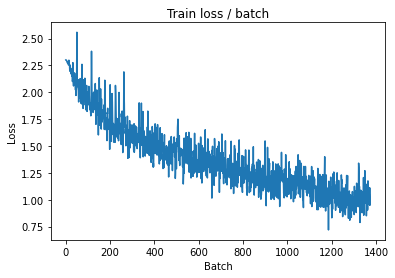


===============> Total time 14s	Avg loss 1.0212	Avg Prec@1 64.42 %	Avg Prec@5 96.67 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 0.9317 (0.9317)	Prec@1  68.0 ( 68.0)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0002	Avg Prec@1 64.83 %	Avg Prec@5 96.65 %



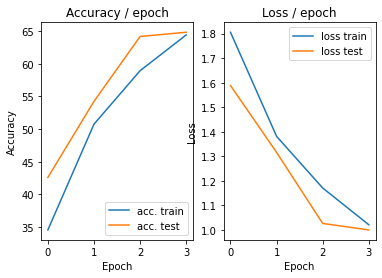

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.194s (0.194s)	Loss 0.9327 (0.9327)	Prec@1  67.2 ( 67.2)	Prec@5  96.1 ( 96.1)


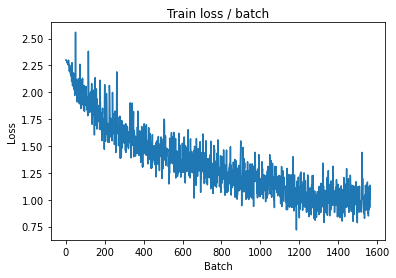

[TRAIN Batch 200/391]	Time 0.031s (0.043s)	Loss 0.8446 (0.9216)	Prec@1  70.3 ( 67.8)	Prec@5  96.1 ( 97.0)


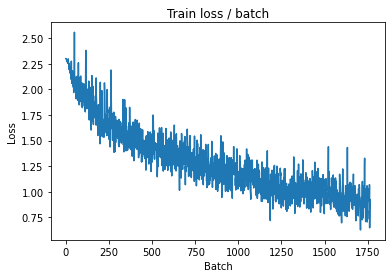


===============> Total time 16s	Avg loss 0.9072	Avg Prec@1 68.28 %	Avg Prec@5 97.24 %

[EVAL Batch 000/079]	Time 0.313s (0.313s)	Loss 0.7791 (0.7791)	Prec@1  70.3 ( 70.3)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.9237	Avg Prec@1 67.74 %	Avg Prec@5 97.15 %



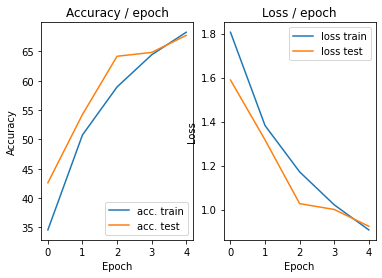

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.186s (0.186s)	Loss 0.9115 (0.9115)	Prec@1  68.0 ( 68.0)	Prec@5  95.3 ( 95.3)


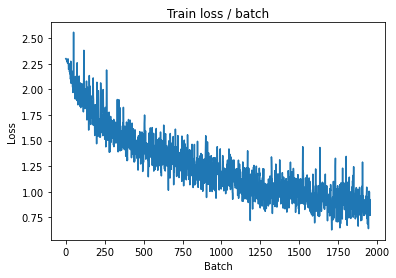

[TRAIN Batch 200/391]	Time 0.063s (0.037s)	Loss 0.8812 (0.8348)	Prec@1  68.0 ( 71.0)	Prec@5 100.0 ( 97.9)


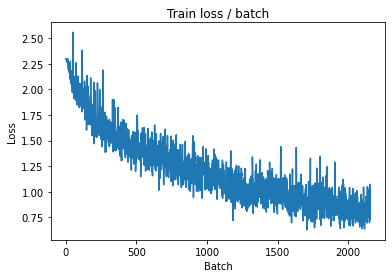


===============> Total time 14s	Avg loss 0.8237	Avg Prec@1 71.42 %	Avg Prec@5 97.86 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 0.9487 (0.9487)	Prec@1  69.5 ( 69.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.8500	Avg Prec@1 70.01 %	Avg Prec@5 98.04 %



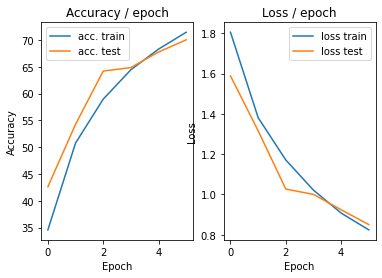

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.179s (0.179s)	Loss 0.9356 (0.9356)	Prec@1  67.2 ( 67.2)	Prec@5  98.4 ( 98.4)


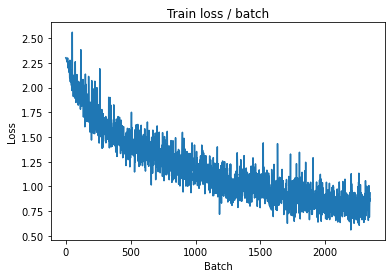

[TRAIN Batch 200/391]	Time 0.044s (0.043s)	Loss 0.6415 (0.7658)	Prec@1  82.0 ( 73.7)	Prec@5 100.0 ( 98.0)


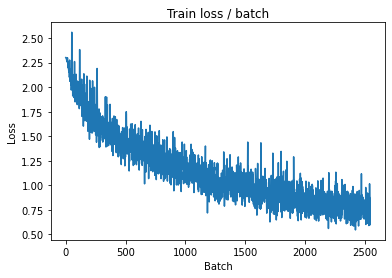


===============> Total time 15s	Avg loss 0.7577	Avg Prec@1 73.76 %	Avg Prec@5 98.18 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.8369 (0.8369)	Prec@1  70.3 ( 70.3)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8201	Avg Prec@1 71.46 %	Avg Prec@5 97.91 %



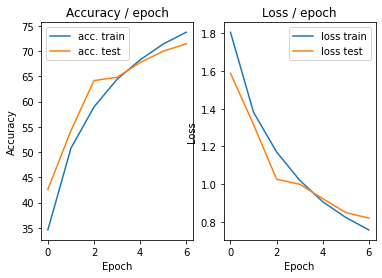

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.196s (0.196s)	Loss 0.7749 (0.7749)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)


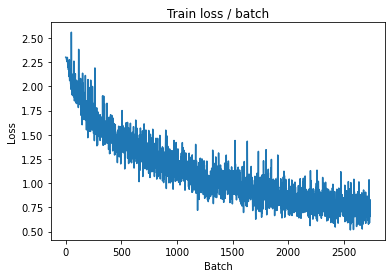

[TRAIN Batch 200/391]	Time 0.057s (0.037s)	Loss 0.7226 (0.7054)	Prec@1  80.5 ( 75.4)	Prec@5  98.4 ( 98.5)


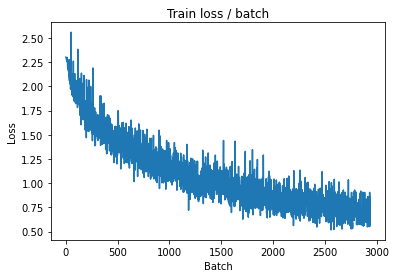


===============> Total time 14s	Avg loss 0.7040	Avg Prec@1 75.51 %	Avg Prec@5 98.44 %

[EVAL Batch 000/079]	Time 0.155s (0.155s)	Loss 0.7864 (0.7864)	Prec@1  68.0 ( 68.0)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.8206	Avg Prec@1 71.61 %	Avg Prec@5 98.07 %



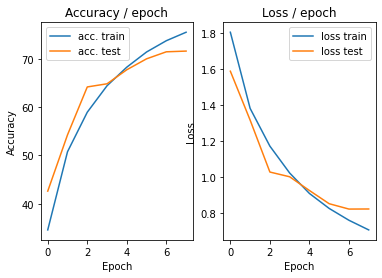

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.183s (0.183s)	Loss 0.8180 (0.8180)	Prec@1  73.4 ( 73.4)	Prec@5  98.4 ( 98.4)


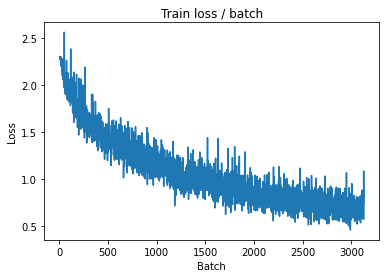

[TRAIN Batch 200/391]	Time 0.026s (0.036s)	Loss 0.5988 (0.6629)	Prec@1  76.6 ( 76.8)	Prec@5  99.2 ( 98.6)


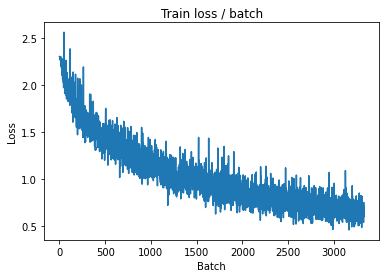


===============> Total time 15s	Avg loss 0.6638	Avg Prec@1 76.87 %	Avg Prec@5 98.61 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 0.6227 (0.6227)	Prec@1  80.5 ( 80.5)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6739	Avg Prec@1 76.60 %	Avg Prec@5 98.45 %



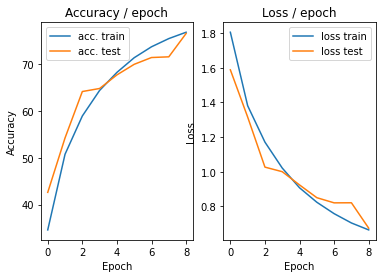

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.6092 (0.6092)	Prec@1  75.8 ( 75.8)	Prec@5 100.0 (100.0)


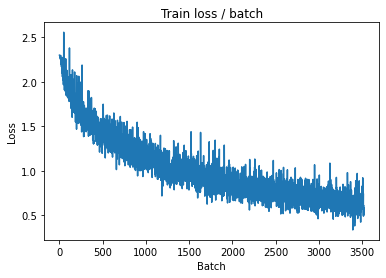

[TRAIN Batch 200/391]	Time 0.034s (0.037s)	Loss 0.5809 (0.6194)	Prec@1  78.9 ( 78.4)	Prec@5  99.2 ( 98.8)


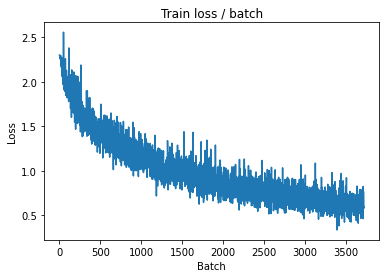


===============> Total time 14s	Avg loss 0.6216	Avg Prec@1 78.25 %	Avg Prec@5 98.83 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.6879 (0.6879)	Prec@1  79.7 ( 79.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6824	Avg Prec@1 75.92 %	Avg Prec@5 98.69 %



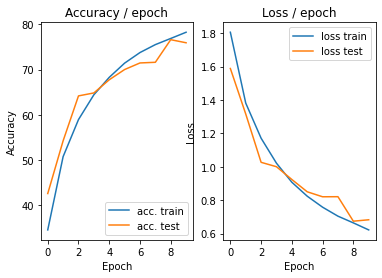

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.202s (0.202s)	Loss 0.5563 (0.5563)	Prec@1  79.7 ( 79.7)	Prec@5  99.2 ( 99.2)


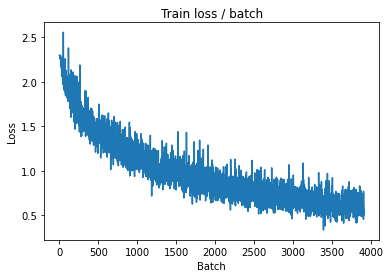

[TRAIN Batch 200/391]	Time 0.018s (0.037s)	Loss 0.5955 (0.5773)	Prec@1  82.0 ( 79.9)	Prec@5  97.7 ( 99.0)


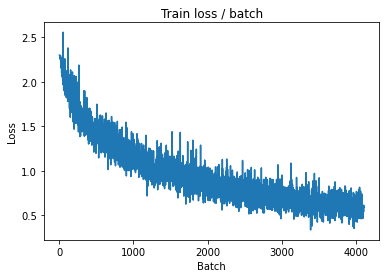


===============> Total time 14s	Avg loss 0.5856	Avg Prec@1 79.51 %	Avg Prec@5 98.95 %

[EVAL Batch 000/079]	Time 0.169s (0.169s)	Loss 0.5893 (0.5893)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6767	Avg Prec@1 76.56 %	Avg Prec@5 98.54 %



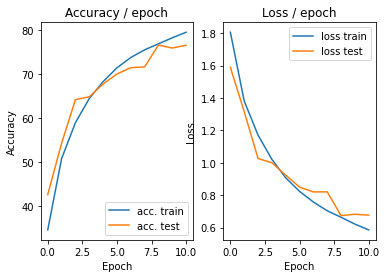

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.296s (0.296s)	Loss 0.7259 (0.7259)	Prec@1  71.9 ( 71.9)	Prec@5  99.2 ( 99.2)


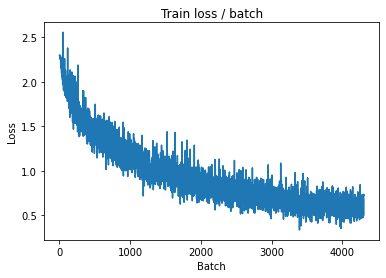

[TRAIN Batch 200/391]	Time 0.015s (0.040s)	Loss 0.5376 (0.5541)	Prec@1  79.7 ( 80.4)	Prec@5 100.0 ( 99.1)


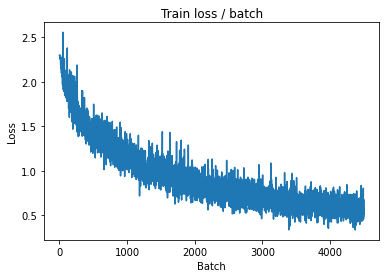


===============> Total time 14s	Avg loss 0.5538	Avg Prec@1 80.55 %	Avg Prec@5 99.10 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 0.5864 (0.5864)	Prec@1  81.2 ( 81.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6482	Avg Prec@1 77.14 %	Avg Prec@5 98.80 %



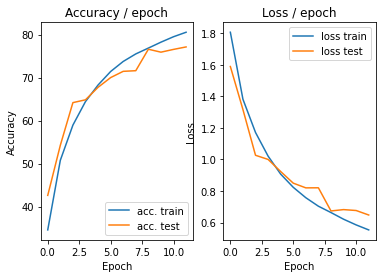

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.180s (0.180s)	Loss 0.7745 (0.7745)	Prec@1  72.7 ( 72.7)	Prec@5  97.7 ( 97.7)


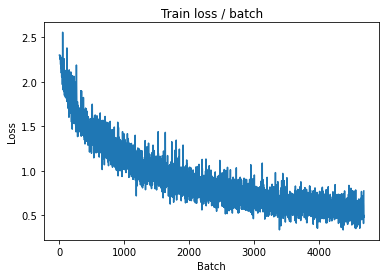

[TRAIN Batch 200/391]	Time 0.009s (0.037s)	Loss 0.6311 (0.5259)	Prec@1  80.5 ( 81.8)	Prec@5  98.4 ( 99.1)


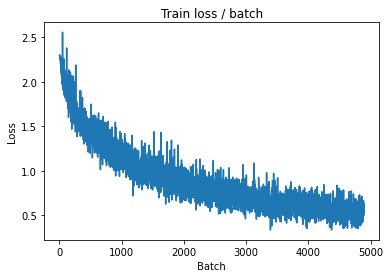


===============> Total time 14s	Avg loss 0.5247	Avg Prec@1 81.69 %	Avg Prec@5 99.19 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.5378 (0.5378)	Prec@1  79.7 ( 79.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6497	Avg Prec@1 77.46 %	Avg Prec@5 98.75 %



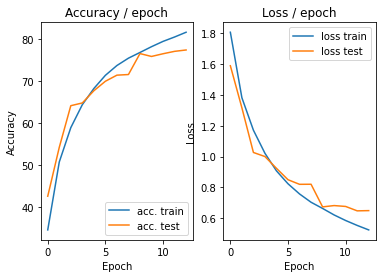

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.215s (0.215s)	Loss 0.5171 (0.5171)	Prec@1  82.8 ( 82.8)	Prec@5  99.2 ( 99.2)


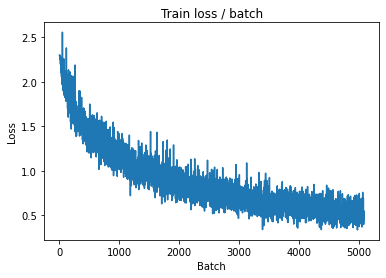

[TRAIN Batch 200/391]	Time 0.048s (0.042s)	Loss 0.4341 (0.4942)	Prec@1  82.8 ( 82.5)	Prec@5 100.0 ( 99.3)


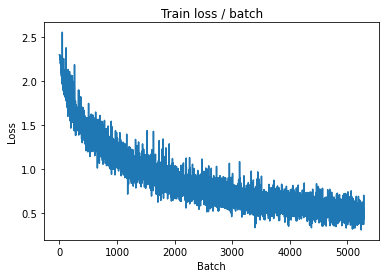


===============> Total time 15s	Avg loss 0.4940	Avg Prec@1 82.69 %	Avg Prec@5 99.24 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 0.5611 (0.5611)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6214	Avg Prec@1 78.64 %	Avg Prec@5 98.84 %



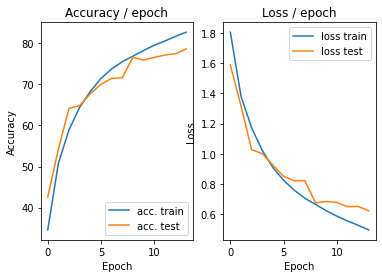

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.192s (0.192s)	Loss 0.3665 (0.3665)	Prec@1  88.3 ( 88.3)	Prec@5  99.2 ( 99.2)


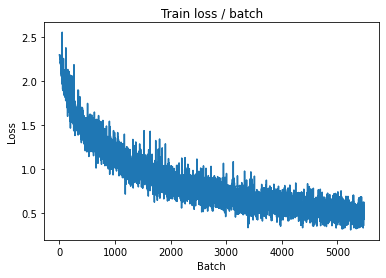

[TRAIN Batch 200/391]	Time 0.015s (0.036s)	Loss 0.5349 (0.4683)	Prec@1  83.6 ( 83.4)	Prec@5  97.7 ( 99.4)


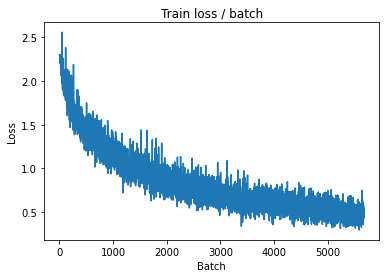


===============> Total time 15s	Avg loss 0.4703	Avg Prec@1 83.38 %	Avg Prec@5 99.35 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 0.5823 (0.5823)	Prec@1  83.6 ( 83.6)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6141	Avg Prec@1 78.83 %	Avg Prec@5 98.83 %



=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.200s (0.200s)	Loss 0.5119 (0.5119)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)


[TRAIN Batch 200/391]	Time 0.014s (0.037s)	Loss 0.4607 (0.4411)	Prec@1  85.9 ( 84.8)	Prec@5  99.2 ( 99.4)



===============> Total time 15s	Avg loss 0.4488	Avg Prec@1 84.49 %	Avg Prec@5 99.38 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 0.6002 (0.6002)	Prec@1  83.6 ( 83.6)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6122	Avg Prec@1 79.22 %	Avg Prec@5 98.85 %



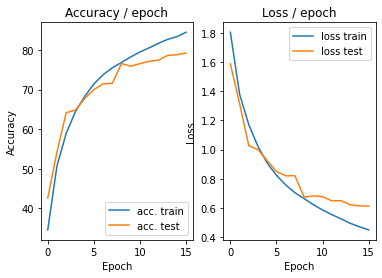

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.196s (0.196s)	Loss 0.5092 (0.5092)	Prec@1  82.8 ( 82.8)	Prec@5  99.2 ( 99.2)


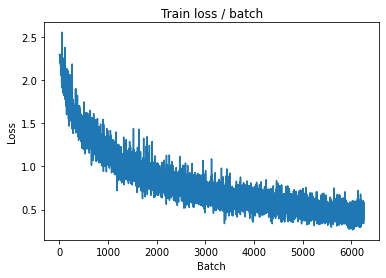

[TRAIN Batch 200/391]	Time 0.042s (0.037s)	Loss 0.6253 (0.4275)	Prec@1  75.0 ( 84.9)	Prec@5  99.2 ( 99.5)


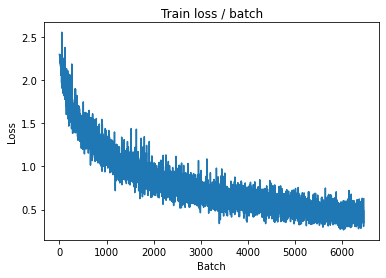


===============> Total time 14s	Avg loss 0.4258	Avg Prec@1 85.03 %	Avg Prec@5 99.45 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 0.5816 (0.5816)	Prec@1  77.3 ( 77.3)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5914	Avg Prec@1 79.97 %	Avg Prec@5 98.91 %



=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.203s (0.203s)	Loss 0.3851 (0.3851)	Prec@1  85.9 ( 85.9)	Prec@5  99.2 ( 99.2)


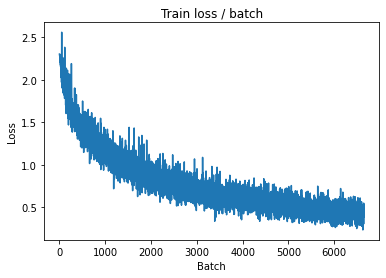

[TRAIN Batch 200/391]	Time 0.066s (0.037s)	Loss 0.4129 (0.4034)	Prec@1  84.4 ( 86.0)	Prec@5 100.0 ( 99.6)



===============> Total time 14s	Avg loss 0.4028	Avg Prec@1 85.93 %	Avg Prec@5 99.58 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 0.6274 (0.6274)	Prec@1  82.8 ( 82.8)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5937	Avg Prec@1 79.92 %	Avg Prec@5 98.92 %



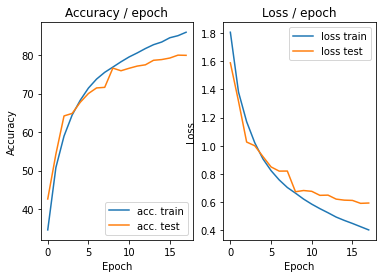

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.267s (0.267s)	Loss 0.5432 (0.5432)	Prec@1  81.2 ( 81.2)	Prec@5  99.2 ( 99.2)


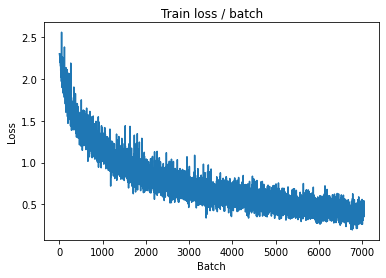

[TRAIN Batch 200/391]	Time 0.044s (0.039s)	Loss 0.4420 (0.3786)	Prec@1  85.2 ( 86.9)	Prec@5  99.2 ( 99.6)


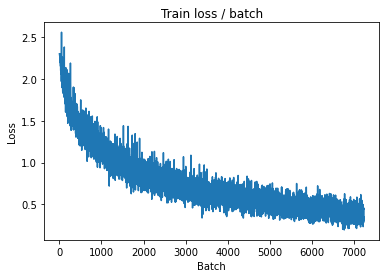


===============> Total time 14s	Avg loss 0.3851	Avg Prec@1 86.62 %	Avg Prec@5 99.59 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 0.5374 (0.5374)	Prec@1  85.2 ( 85.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5993	Avg Prec@1 79.85 %	Avg Prec@5 98.95 %



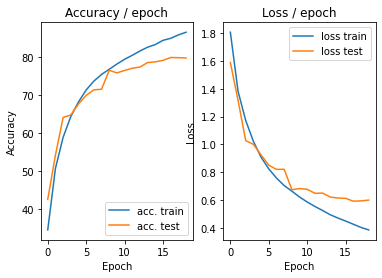

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 0.3768 (0.3768)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)


[TRAIN Batch 200/391]	Time 0.058s (0.037s)	Loss 0.3721 (0.3655)	Prec@1  88.3 ( 87.3)	Prec@5 100.0 ( 99.6)


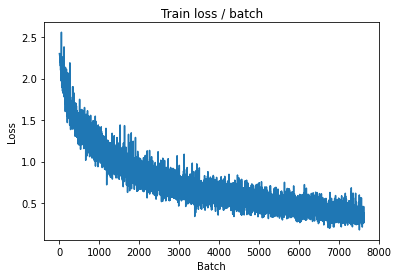


===============> Total time 14s	Avg loss 0.3663	Avg Prec@1 87.37 %	Avg Prec@5 99.61 %

[EVAL Batch 000/079]	Time 0.176s (0.176s)	Loss 0.5425 (0.5425)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5940	Avg Prec@1 80.43 %	Avg Prec@5 98.81 %



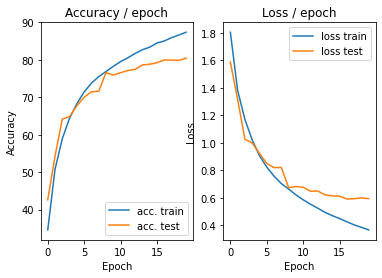

In [15]:
def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
  
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
        # Update lr
        lr_sched.step()

main(128, 0.1, cuda=True, epochs=20)

## Dropout

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.223s (0.223s)	Loss 2.3027 (2.3027)	Prec@1   7.0 (  7.0)	Prec@5  52.3 ( 52.3)


<Figure size 432x288 with 0 Axes>

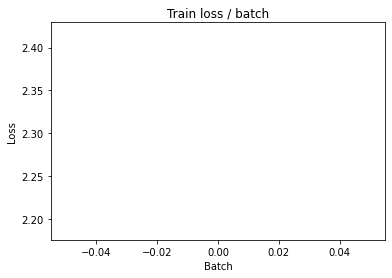

[TRAIN Batch 200/391]	Time 0.064s (0.039s)	Loss 1.7391 (1.9939)	Prec@1  36.7 ( 26.0)	Prec@5  85.9 ( 77.2)


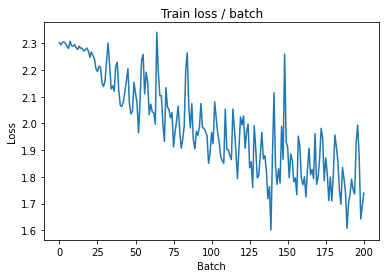


===============> Total time 14s	Avg loss 1.8322	Avg Prec@1 32.83 %	Avg Prec@5 82.85 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 1.4560 (1.4560)	Prec@1  54.7 ( 54.7)	Prec@5  91.4 ( 91.4)

===============> Total time 2s	Avg loss 1.4654	Avg Prec@1 46.82 %	Avg Prec@5 92.36 %



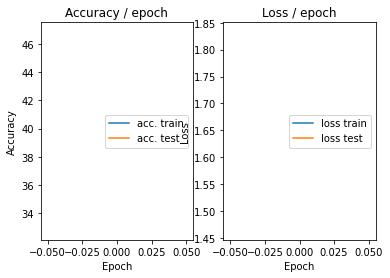

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.178s (0.178s)	Loss 1.5845 (1.5845)	Prec@1  43.8 ( 43.8)	Prec@5  88.3 ( 88.3)


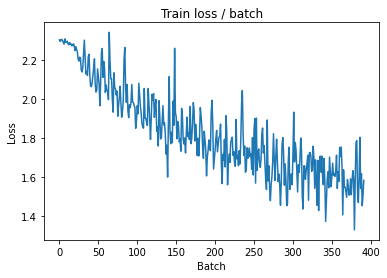

[TRAIN Batch 200/391]	Time 0.013s (0.037s)	Loss 1.3352 (1.4990)	Prec@1  53.1 ( 46.1)	Prec@5  92.2 ( 91.5)


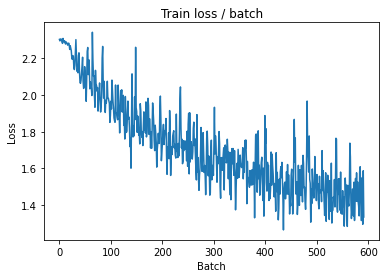


===============> Total time 14s	Avg loss 1.4412	Avg Prec@1 48.38 %	Avg Prec@5 92.32 %

[EVAL Batch 000/079]	Time 0.173s (0.173s)	Loss 1.1703 (1.1703)	Prec@1  61.7 ( 61.7)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.2334	Avg Prec@1 56.31 %	Avg Prec@5 95.16 %



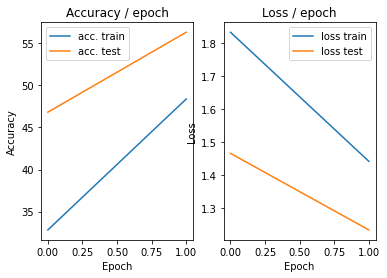

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.197s (0.197s)	Loss 1.2500 (1.2500)	Prec@1  53.9 ( 53.9)	Prec@5  93.0 ( 93.0)


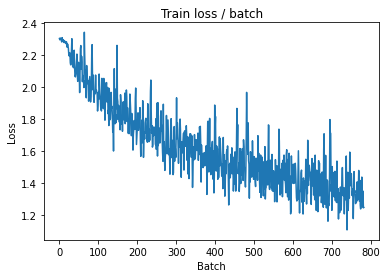

[TRAIN Batch 200/391]	Time 0.046s (0.043s)	Loss 1.0938 (1.2751)	Prec@1  57.0 ( 55.0)	Prec@5  96.1 ( 94.3)


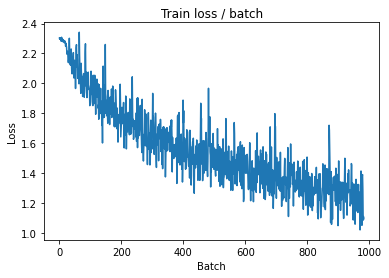


===============> Total time 15s	Avg loss 1.2364	Avg Prec@1 56.48 %	Avg Prec@5 94.73 %

[EVAL Batch 000/079]	Time 0.166s (0.166s)	Loss 1.0939 (1.0939)	Prec@1  65.6 ( 65.6)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.0996	Avg Prec@1 61.47 %	Avg Prec@5 96.29 %



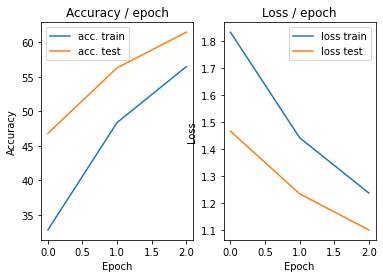

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.203s (0.203s)	Loss 1.0598 (1.0598)	Prec@1  64.1 ( 64.1)	Prec@5  96.9 ( 96.9)


[TRAIN Batch 200/391]	Time 0.067s (0.037s)	Loss 1.1815 (1.1074)	Prec@1  57.8 ( 61.0)	Prec@5  96.1 ( 95.9)



===============> Total time 14s	Avg loss 1.0869	Avg Prec@1 61.81 %	Avg Prec@5 96.00 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 1.0663 (1.0663)	Prec@1  65.6 ( 65.6)	Prec@5  95.3 ( 95.3)

===============> Total time 2s	Avg loss 1.0841	Avg Prec@1 61.90 %	Avg Prec@5 96.53 %



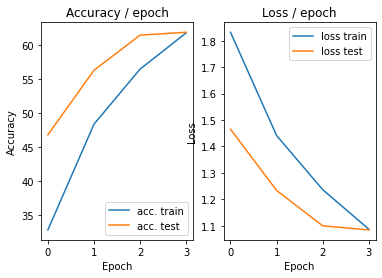

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 1.1454 (1.1454)	Prec@1  58.6 ( 58.6)	Prec@5  95.3 ( 95.3)


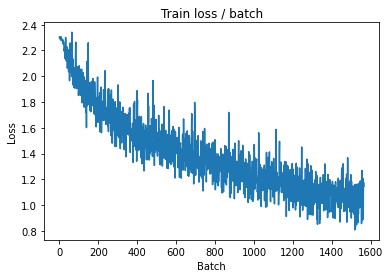

[TRAIN Batch 200/391]	Time 0.062s (0.045s)	Loss 1.0923 (0.9911)	Prec@1  61.7 ( 65.2)	Prec@5  93.0 ( 96.7)



===============> Total time 16s	Avg loss 0.9746	Avg Prec@1 65.87 %	Avg Prec@5 96.90 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 1.0797 (1.0797)	Prec@1  64.8 ( 64.8)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 1.0902	Avg Prec@1 61.59 %	Avg Prec@5 96.64 %



=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.186s (0.186s)	Loss 1.2342 (1.2342)	Prec@1  57.8 ( 57.8)	Prec@5  95.3 ( 95.3)


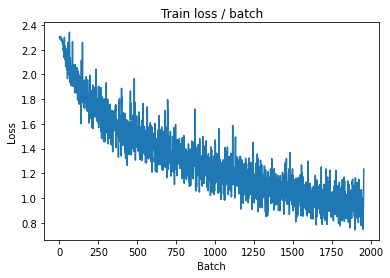

[TRAIN Batch 200/391]	Time 0.041s (0.042s)	Loss 0.9127 (0.9054)	Prec@1  67.2 ( 68.3)	Prec@5  96.1 ( 97.3)


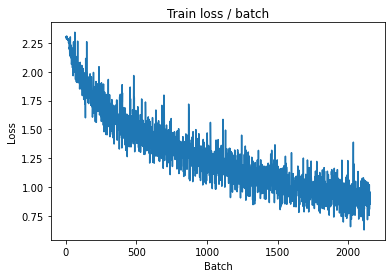


===============> Total time 15s	Avg loss 0.8963	Avg Prec@1 68.74 %	Avg Prec@5 97.37 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 0.8705 (0.8705)	Prec@1  74.2 ( 74.2)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.9537	Avg Prec@1 66.46 %	Avg Prec@5 97.30 %



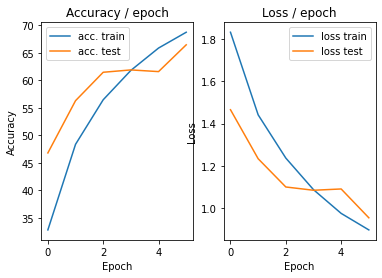

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.198s (0.198s)	Loss 0.9308 (0.9308)	Prec@1  63.3 ( 63.3)	Prec@5  97.7 ( 97.7)


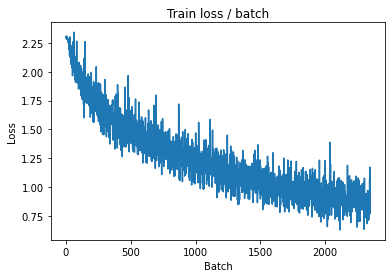

[TRAIN Batch 200/391]	Time 0.015s (0.037s)	Loss 0.8310 (0.8433)	Prec@1  71.9 ( 70.7)	Prec@5  99.2 ( 97.9)


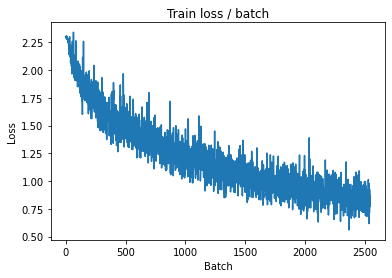


===============> Total time 15s	Avg loss 0.8361	Avg Prec@1 70.84 %	Avg Prec@5 97.81 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.7614 (0.7614)	Prec@1  75.0 ( 75.0)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8151	Avg Prec@1 72.47 %	Avg Prec@5 97.69 %



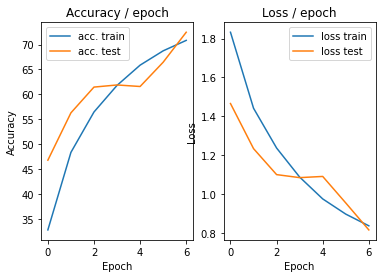

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.190s (0.190s)	Loss 0.9396 (0.9396)	Prec@1  69.5 ( 69.5)	Prec@5  95.3 ( 95.3)


[TRAIN Batch 200/391]	Time 0.014s (0.037s)	Loss 0.7648 (0.7828)	Prec@1  73.4 ( 72.6)	Prec@5  98.4 ( 98.0)


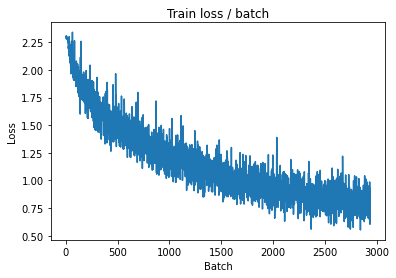


===============> Total time 14s	Avg loss 0.7790	Avg Prec@1 72.69 %	Avg Prec@5 98.05 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.7831 (0.7831)	Prec@1  71.1 ( 71.1)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8238	Avg Prec@1 71.90 %	Avg Prec@5 97.82 %



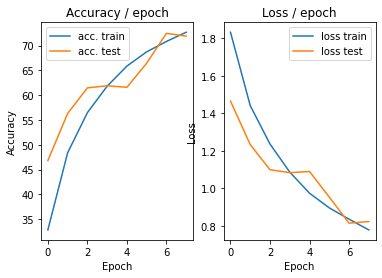

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.188s (0.188s)	Loss 1.0327 (1.0327)	Prec@1  70.3 ( 70.3)	Prec@5  97.7 ( 97.7)


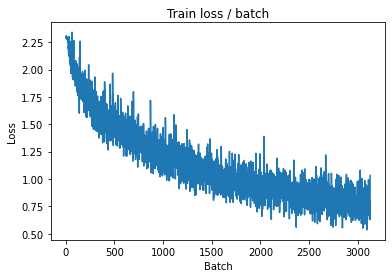

[TRAIN Batch 200/391]	Time 0.064s (0.038s)	Loss 0.6628 (0.7387)	Prec@1  76.6 ( 74.4)	Prec@5  98.4 ( 98.2)


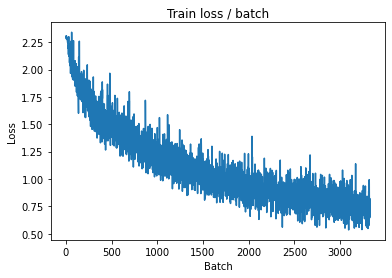


===============> Total time 14s	Avg loss 0.7363	Avg Prec@1 74.43 %	Avg Prec@5 98.17 %

[EVAL Batch 000/079]	Time 0.173s (0.173s)	Loss 0.6435 (0.6435)	Prec@1  80.5 ( 80.5)	Prec@5  97.7 ( 97.7)

===============> Total time 3s	Avg loss 0.7117	Avg Prec@1 75.64 %	Avg Prec@5 98.37 %



=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.192s (0.192s)	Loss 0.6544 (0.6544)	Prec@1  76.6 ( 76.6)	Prec@5  99.2 ( 99.2)


[TRAIN Batch 200/391]	Time 0.054s (0.037s)	Loss 0.6905 (0.7007)	Prec@1  75.0 ( 75.6)	Prec@5  97.7 ( 98.3)



===============> Total time 14s	Avg loss 0.6995	Avg Prec@1 75.74 %	Avg Prec@5 98.37 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 0.6404 (0.6404)	Prec@1  78.9 ( 78.9)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.7090	Avg Prec@1 75.85 %	Avg Prec@5 98.41 %



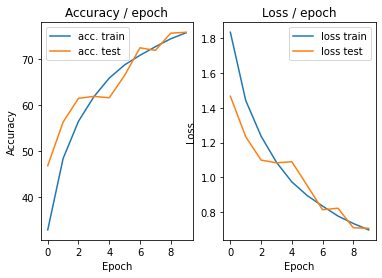

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.196s (0.196s)	Loss 0.7629 (0.7629)	Prec@1  71.9 ( 71.9)	Prec@5  97.7 ( 97.7)


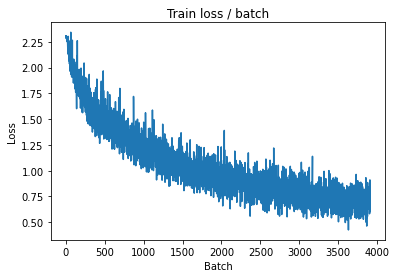

[TRAIN Batch 200/391]	Time 0.020s (0.037s)	Loss 1.0226 (0.6661)	Prec@1  71.1 ( 76.6)	Prec@5  97.7 ( 98.5)


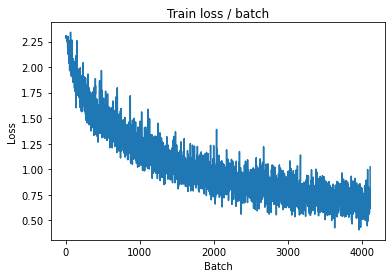


===============> Total time 14s	Avg loss 0.6685	Avg Prec@1 76.60 %	Avg Prec@5 98.51 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 0.6238 (0.6238)	Prec@1  78.1 ( 78.1)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6710	Avg Prec@1 76.53 %	Avg Prec@5 98.64 %



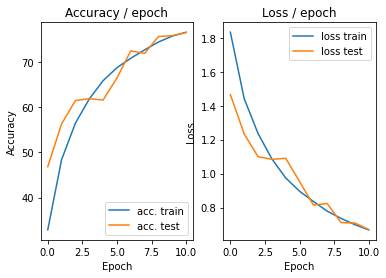

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 0.7394 (0.7394)	Prec@1  75.8 ( 75.8)	Prec@5  99.2 ( 99.2)


[TRAIN Batch 200/391]	Time 0.014s (0.041s)	Loss 0.6720 (0.6425)	Prec@1  78.1 ( 77.6)	Prec@5  96.9 ( 98.7)


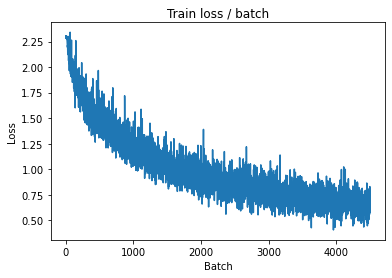


===============> Total time 14s	Avg loss 0.6364	Avg Prec@1 77.79 %	Avg Prec@5 98.74 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.6601 (0.6601)	Prec@1  82.0 ( 82.0)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6750	Avg Prec@1 77.08 %	Avg Prec@5 98.56 %



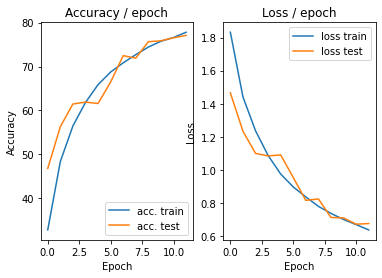

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 0.6099 (0.6099)	Prec@1  82.0 ( 82.0)	Prec@5  98.4 ( 98.4)


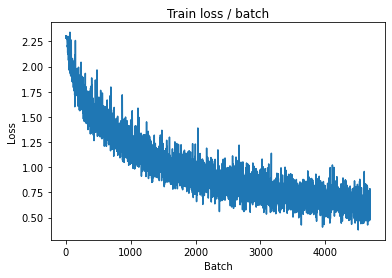

[TRAIN Batch 200/391]	Time 0.034s (0.039s)	Loss 0.6874 (0.6061)	Prec@1  77.3 ( 78.8)	Prec@5  99.2 ( 98.9)


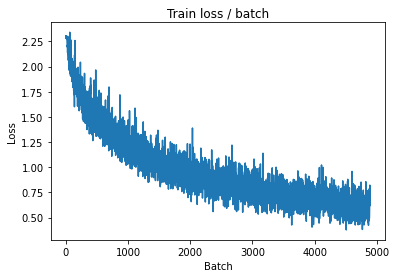


===============> Total time 14s	Avg loss 0.6099	Avg Prec@1 78.74 %	Avg Prec@5 98.84 %

[EVAL Batch 000/079]	Time 0.173s (0.173s)	Loss 0.6245 (0.6245)	Prec@1  80.5 ( 80.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6678	Avg Prec@1 76.98 %	Avg Prec@5 98.51 %



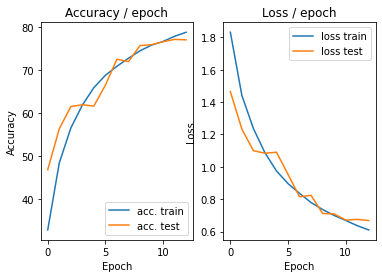

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 0.5329 (0.5329)	Prec@1  81.2 ( 81.2)	Prec@5 100.0 (100.0)


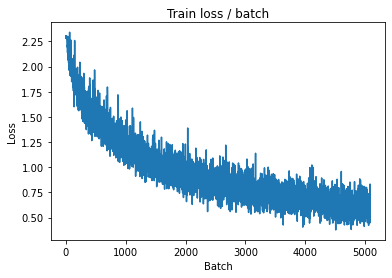

[TRAIN Batch 200/391]	Time 0.072s (0.037s)	Loss 0.7333 (0.5782)	Prec@1  75.8 ( 79.8)	Prec@5  98.4 ( 98.9)


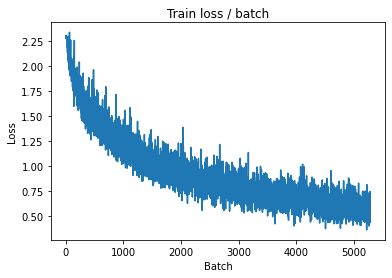


===============> Total time 15s	Avg loss 0.5896	Avg Prec@1 79.38 %	Avg Prec@5 98.89 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 0.5606 (0.5606)	Prec@1  82.8 ( 82.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6219	Avg Prec@1 78.57 %	Avg Prec@5 98.65 %



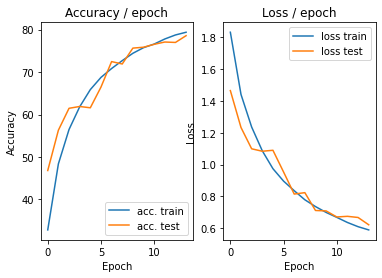

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 0.5566 (0.5566)	Prec@1  77.3 ( 77.3)	Prec@5 100.0 (100.0)


[TRAIN Batch 200/391]	Time 0.051s (0.037s)	Loss 0.6414 (0.5646)	Prec@1  79.7 ( 80.2)	Prec@5  99.2 ( 99.0)


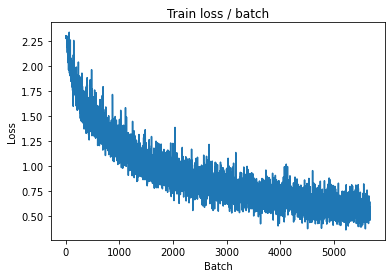


===============> Total time 14s	Avg loss 0.5652	Avg Prec@1 80.17 %	Avg Prec@5 99.00 %

[EVAL Batch 000/079]	Time 0.181s (0.181s)	Loss 0.5440 (0.5440)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5978	Avg Prec@1 79.71 %	Avg Prec@5 98.65 %



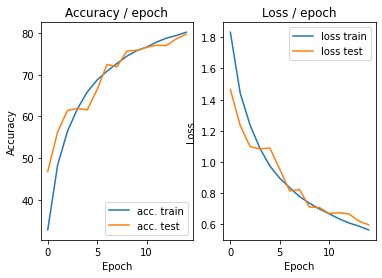

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.205s (0.205s)	Loss 0.6172 (0.6172)	Prec@1  84.4 ( 84.4)	Prec@5  97.7 ( 97.7)


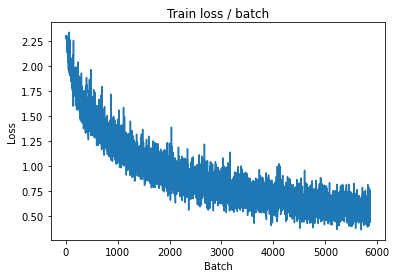

[TRAIN Batch 200/391]	Time 0.048s (0.037s)	Loss 0.5707 (0.5454)	Prec@1  81.2 ( 81.0)	Prec@5 100.0 ( 99.1)


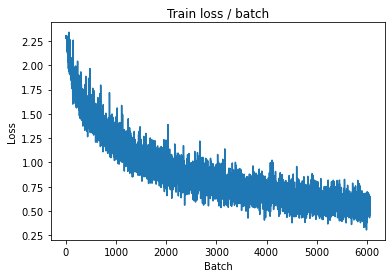


===============> Total time 15s	Avg loss 0.5515	Avg Prec@1 80.76 %	Avg Prec@5 99.09 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 0.5258 (0.5258)	Prec@1  82.0 ( 82.0)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6095	Avg Prec@1 79.02 %	Avg Prec@5 98.78 %



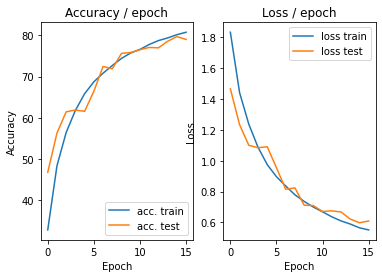

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.204s (0.204s)	Loss 0.4468 (0.4468)	Prec@1  82.0 ( 82.0)	Prec@5 100.0 (100.0)


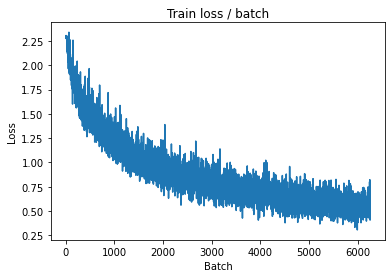

[TRAIN Batch 200/391]	Time 0.036s (0.038s)	Loss 0.6385 (0.5352)	Prec@1  76.6 ( 81.5)	Prec@5  98.4 ( 99.1)


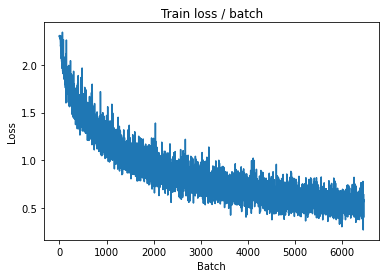


===============> Total time 14s	Avg loss 0.5333	Avg Prec@1 81.47 %	Avg Prec@5 99.07 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 0.5785 (0.5785)	Prec@1  80.5 ( 80.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6043	Avg Prec@1 79.36 %	Avg Prec@5 98.80 %



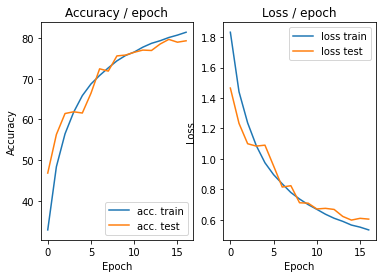

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.217s (0.217s)	Loss 0.3753 (0.3753)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


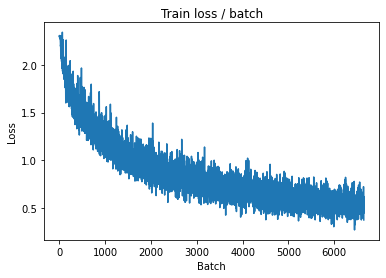

[TRAIN Batch 200/391]	Time 0.070s (0.037s)	Loss 0.3851 (0.5122)	Prec@1  85.9 ( 81.8)	Prec@5 100.0 ( 99.2)


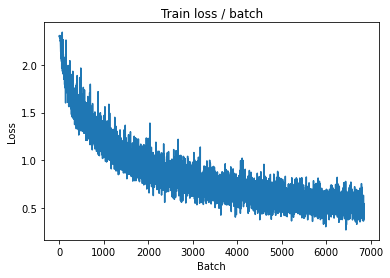


===============> Total time 14s	Avg loss 0.5124	Avg Prec@1 81.86 %	Avg Prec@5 99.19 %

[EVAL Batch 000/079]	Time 0.186s (0.186s)	Loss 0.5171 (0.5171)	Prec@1  83.6 ( 83.6)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5875	Avg Prec@1 80.41 %	Avg Prec@5 98.87 %



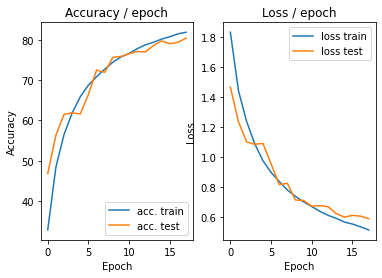

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.198s (0.198s)	Loss 0.3967 (0.3967)	Prec@1  85.9 ( 85.9)	Prec@5 100.0 (100.0)


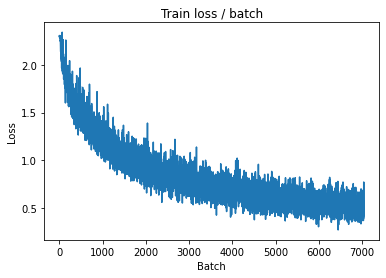

[TRAIN Batch 200/391]	Time 0.028s (0.041s)	Loss 0.5222 (0.4934)	Prec@1  78.9 ( 83.0)	Prec@5  99.2 ( 99.2)


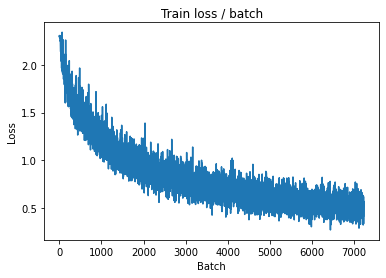


===============> Total time 15s	Avg loss 0.4987	Avg Prec@1 82.60 %	Avg Prec@5 99.21 %

[EVAL Batch 000/079]	Time 0.173s (0.173s)	Loss 0.5365 (0.5365)	Prec@1  81.2 ( 81.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5749	Avg Prec@1 80.75 %	Avg Prec@5 98.80 %



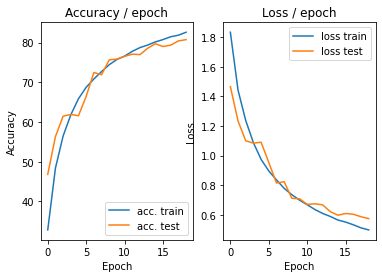

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.182s (0.182s)	Loss 0.5288 (0.5288)	Prec@1  85.2 ( 85.2)	Prec@5  99.2 ( 99.2)


[TRAIN Batch 200/391]	Time 0.014s (0.037s)	Loss 0.4099 (0.4870)	Prec@1  82.0 ( 82.7)	Prec@5  99.2 ( 99.3)


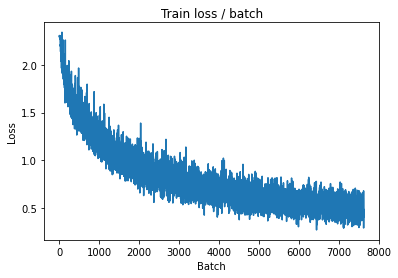


===============> Total time 14s	Avg loss 0.4888	Avg Prec@1 82.82 %	Avg Prec@5 99.28 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 0.4792 (0.4792)	Prec@1  84.4 ( 84.4)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5692	Avg Prec@1 80.81 %	Avg Prec@5 98.83 %



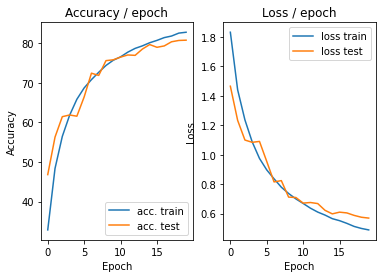

In [16]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

main(128, 0.1, cuda=True, epochs=20)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.596s (0.596s)	Loss 2.3001 (2.3001)	Prec@1  10.9 ( 10.9)	Prec@5  56.2 ( 56.2)


<Figure size 432x288 with 0 Axes>

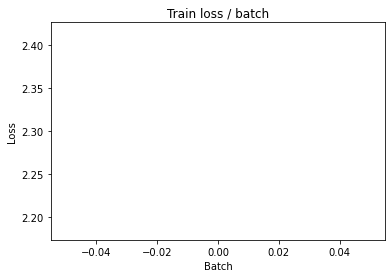

[TRAIN Batch 200/391]	Time 0.018s (0.041s)	Loss 1.4373 (1.6589)	Prec@1  48.4 ( 38.4)	Prec@5  92.2 ( 88.5)


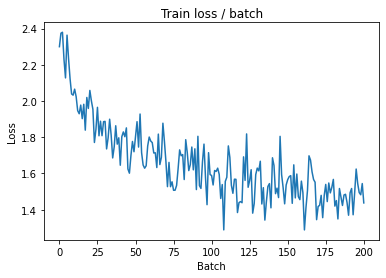


===============> Total time 15s	Avg loss 1.5111	Avg Prec@1 44.33 %	Avg Prec@5 91.08 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 1.5239 (1.5239)	Prec@1  46.9 ( 46.9)	Prec@5  92.2 ( 92.2)

===============> Total time 2s	Avg loss 1.5803	Avg Prec@1 44.69 %	Avg Prec@5 91.33 %



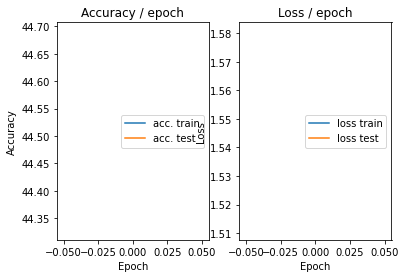

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.198s (0.198s)	Loss 1.2948 (1.2948)	Prec@1  57.0 ( 57.0)	Prec@5  94.5 ( 94.5)


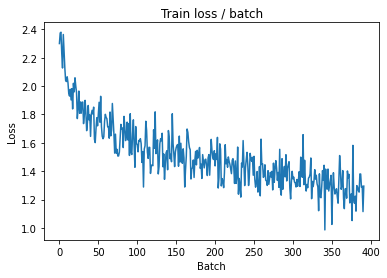

[TRAIN Batch 200/391]	Time 0.023s (0.041s)	Loss 1.1138 (1.1928)	Prec@1  60.9 ( 56.9)	Prec@5  93.0 ( 95.4)


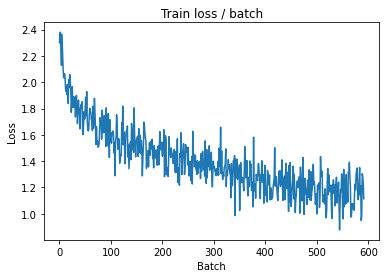


===============> Total time 15s	Avg loss 1.1435	Avg Prec@1 58.83 %	Avg Prec@5 95.83 %

[EVAL Batch 000/079]	Time 0.169s (0.169s)	Loss 1.3065 (1.3065)	Prec@1  56.2 ( 56.2)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.4961	Avg Prec@1 52.00 %	Avg Prec@5 89.23 %



=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.183s (0.183s)	Loss 1.1167 (1.1167)	Prec@1  63.3 ( 63.3)	Prec@5  93.0 ( 93.0)


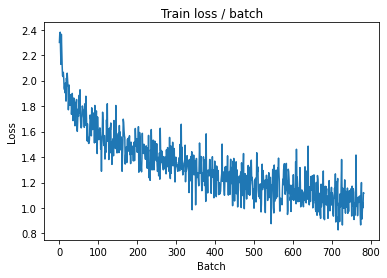

[TRAIN Batch 200/391]	Time 0.049s (0.037s)	Loss 0.9813 (1.0069)	Prec@1  67.2 ( 64.1)	Prec@5  95.3 ( 96.8)



===============> Total time 14s	Avg loss 0.9793	Avg Prec@1 65.27 %	Avg Prec@5 96.91 %

[EVAL Batch 000/079]	Time 0.178s (0.178s)	Loss 0.7768 (0.7768)	Prec@1  75.0 ( 75.0)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8786	Avg Prec@1 69.08 %	Avg Prec@5 97.77 %



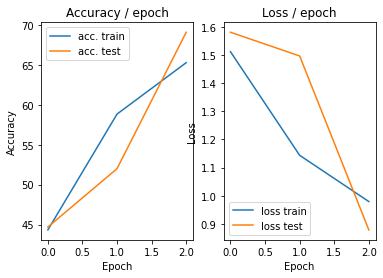

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 0.7160 (0.7160)	Prec@1  73.4 ( 73.4)	Prec@5 100.0 (100.0)


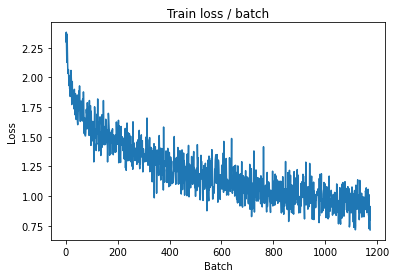

[TRAIN Batch 200/391]	Time 0.051s (0.038s)	Loss 0.8579 (0.8828)	Prec@1  70.3 ( 68.8)	Prec@5  99.2 ( 97.7)


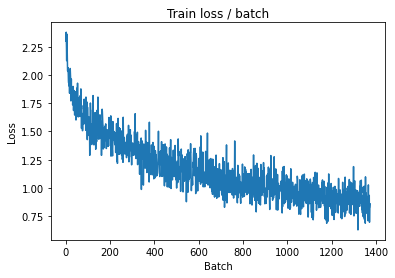


===============> Total time 15s	Avg loss 0.8727	Avg Prec@1 69.15 %	Avg Prec@5 97.64 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 0.7434 (0.7434)	Prec@1  78.1 ( 78.1)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8079	Avg Prec@1 71.60 %	Avg Prec@5 97.82 %



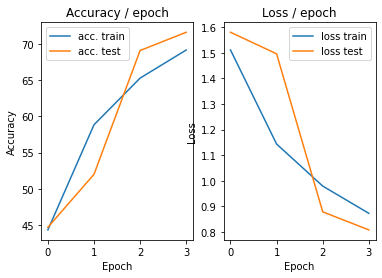

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.206s (0.206s)	Loss 0.7594 (0.7594)	Prec@1  72.7 ( 72.7)	Prec@5  98.4 ( 98.4)


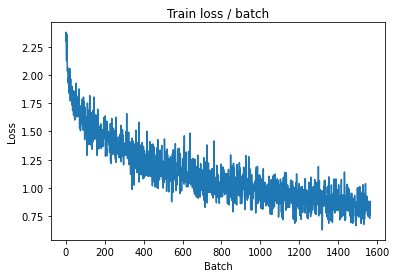

[TRAIN Batch 200/391]	Time 0.061s (0.037s)	Loss 0.6336 (0.8076)	Prec@1  77.3 ( 71.5)	Prec@5  99.2 ( 97.9)


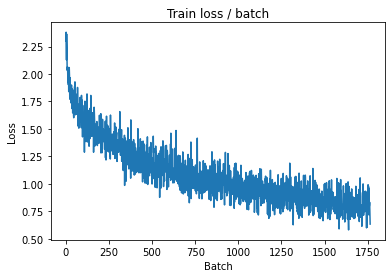


===============> Total time 14s	Avg loss 0.8006	Avg Prec@1 71.99 %	Avg Prec@5 97.86 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 0.7706 (0.7706)	Prec@1  70.3 ( 70.3)	Prec@5  96.9 ( 96.9)

===============> Total time 2s	Avg loss 0.8244	Avg Prec@1 71.25 %	Avg Prec@5 97.58 %



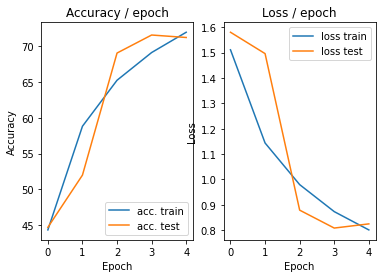

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.192s (0.192s)	Loss 0.6935 (0.6935)	Prec@1  78.1 ( 78.1)	Prec@5 100.0 (100.0)


[TRAIN Batch 200/391]	Time 0.015s (0.036s)	Loss 0.7466 (0.7441)	Prec@1  75.0 ( 73.8)	Prec@5  96.9 ( 98.4)


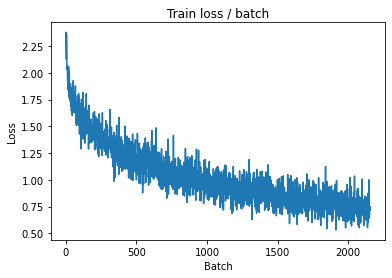


===============> Total time 14s	Avg loss 0.7404	Avg Prec@1 74.03 %	Avg Prec@5 98.27 %

[EVAL Batch 000/079]	Time 0.244s (0.244s)	Loss 0.6343 (0.6343)	Prec@1  81.2 ( 81.2)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.7102	Avg Prec@1 75.39 %	Avg Prec@5 98.29 %



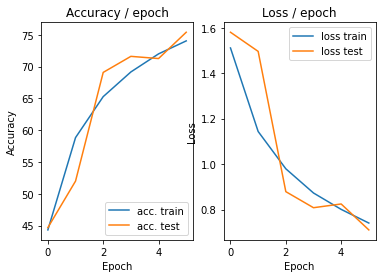

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.231s (0.231s)	Loss 0.6369 (0.6369)	Prec@1  78.1 ( 78.1)	Prec@5  99.2 ( 99.2)


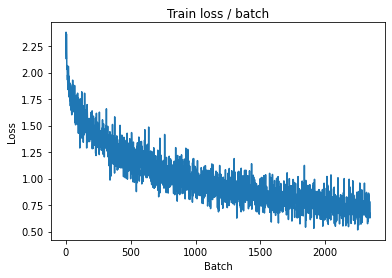

[TRAIN Batch 200/391]	Time 0.015s (0.037s)	Loss 0.7542 (0.7019)	Prec@1  68.8 ( 75.2)	Prec@5  99.2 ( 98.5)


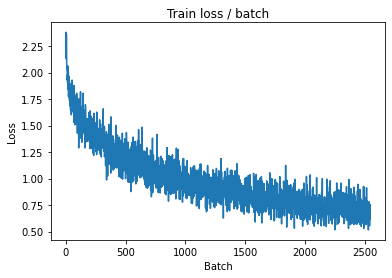


===============> Total time 14s	Avg loss 0.6959	Avg Prec@1 75.40 %	Avg Prec@5 98.48 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 0.7781 (0.7781)	Prec@1  73.4 ( 73.4)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8161	Avg Prec@1 71.40 %	Avg Prec@5 98.19 %



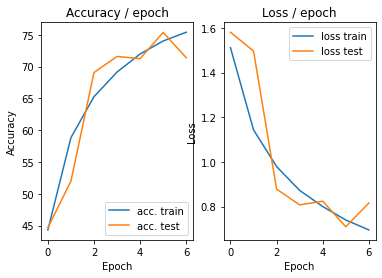

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.200s (0.200s)	Loss 0.7691 (0.7691)	Prec@1  75.8 ( 75.8)	Prec@5  96.1 ( 96.1)


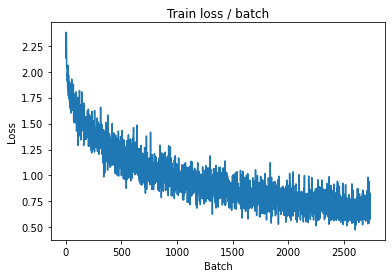

[TRAIN Batch 200/391]	Time 0.013s (0.038s)	Loss 0.7520 (0.6619)	Prec@1  74.2 ( 76.9)	Prec@5  99.2 ( 98.6)


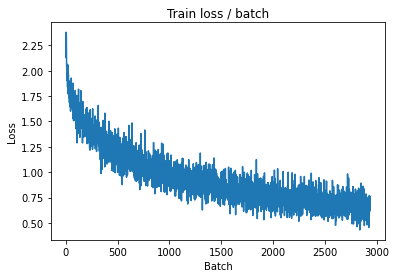


===============> Total time 15s	Avg loss 0.6622	Avg Prec@1 76.80 %	Avg Prec@5 98.62 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 0.6101 (0.6101)	Prec@1  78.1 ( 78.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6735	Avg Prec@1 76.44 %	Avg Prec@5 98.66 %



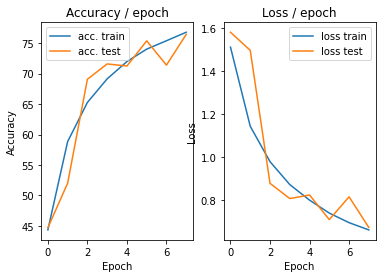

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.188s (0.188s)	Loss 0.5728 (0.5728)	Prec@1  82.8 ( 82.8)	Prec@5  99.2 ( 99.2)


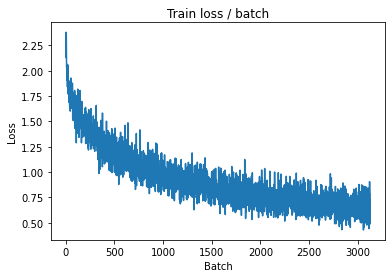

[TRAIN Batch 200/391]	Time 0.065s (0.041s)	Loss 0.6073 (0.6330)	Prec@1  76.6 ( 77.7)	Prec@5  99.2 ( 98.7)



===============> Total time 15s	Avg loss 0.6269	Avg Prec@1 77.92 %	Avg Prec@5 98.74 %

[EVAL Batch 000/079]	Time 0.177s (0.177s)	Loss 0.7163 (0.7163)	Prec@1  74.2 ( 74.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8321	Avg Prec@1 72.45 %	Avg Prec@5 98.23 %



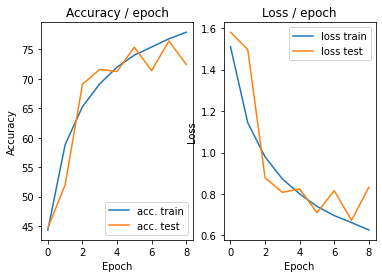

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.190s (0.190s)	Loss 0.7770 (0.7770)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)


[TRAIN Batch 200/391]	Time 0.014s (0.037s)	Loss 0.6811 (0.5998)	Prec@1  80.5 ( 79.0)	Prec@5  96.9 ( 98.8)


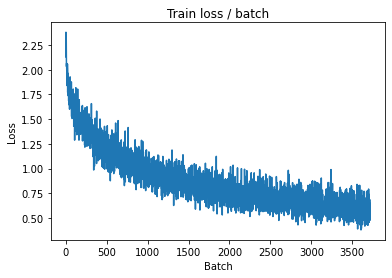


===============> Total time 14s	Avg loss 0.6005	Avg Prec@1 79.01 %	Avg Prec@5 98.80 %

[EVAL Batch 000/079]	Time 0.166s (0.166s)	Loss 0.5418 (0.5418)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6132	Avg Prec@1 78.79 %	Avg Prec@5 98.91 %



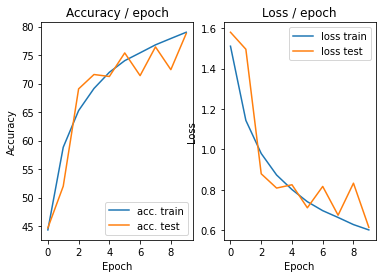

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.202s (0.202s)	Loss 0.6373 (0.6373)	Prec@1  75.8 ( 75.8)	Prec@5 100.0 (100.0)


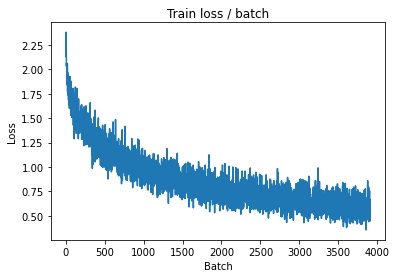

[TRAIN Batch 200/391]	Time 0.014s (0.042s)	Loss 0.7582 (0.5730)	Prec@1  78.1 ( 79.8)	Prec@5  96.1 ( 98.9)


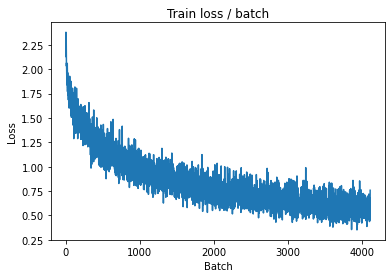


===============> Total time 15s	Avg loss 0.5754	Avg Prec@1 79.76 %	Avg Prec@5 98.95 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 0.5985 (0.5985)	Prec@1  77.3 ( 77.3)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6871	Avg Prec@1 76.50 %	Avg Prec@5 98.25 %



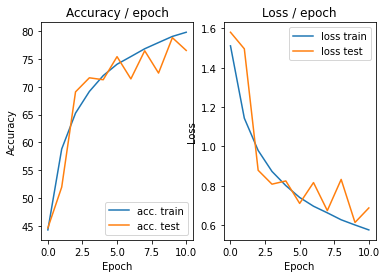

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.196s (0.196s)	Loss 0.7014 (0.7014)	Prec@1  76.6 ( 76.6)	Prec@5  97.7 ( 97.7)


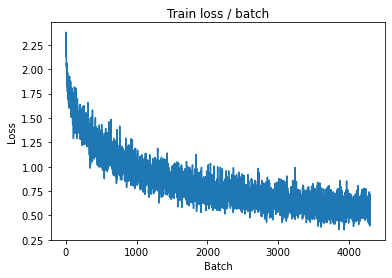

[TRAIN Batch 200/391]	Time 0.016s (0.038s)	Loss 0.4504 (0.5669)	Prec@1  84.4 ( 80.1)	Prec@5  99.2 ( 99.1)


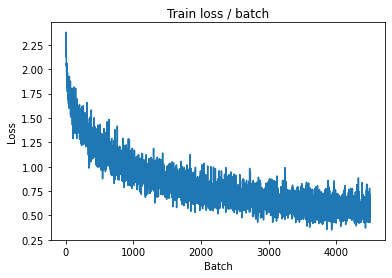


===============> Total time 14s	Avg loss 0.5595	Avg Prec@1 80.42 %	Avg Prec@5 99.01 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 0.6055 (0.6055)	Prec@1  79.7 ( 79.7)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6021	Avg Prec@1 78.81 %	Avg Prec@5 99.01 %



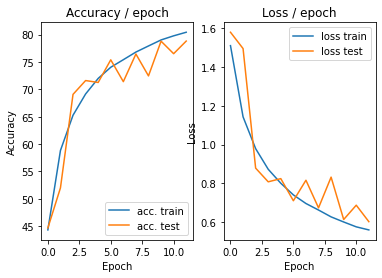

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.182s (0.182s)	Loss 0.5365 (0.5365)	Prec@1  81.2 ( 81.2)	Prec@5 100.0 (100.0)


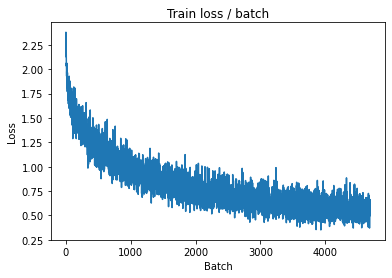

[TRAIN Batch 200/391]	Time 0.042s (0.036s)	Loss 0.4691 (0.5283)	Prec@1  82.8 ( 81.5)	Prec@5  99.2 ( 99.1)


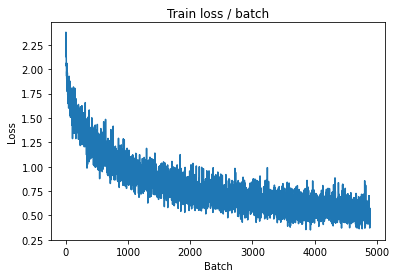


===============> Total time 15s	Avg loss 0.5348	Avg Prec@1 81.29 %	Avg Prec@5 99.09 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 0.6567 (0.6567)	Prec@1  75.0 ( 75.0)	Prec@5 100.0 (100.0)

===============> Total time 2s	Avg loss 0.6871	Avg Prec@1 76.74 %	Avg Prec@5 98.66 %



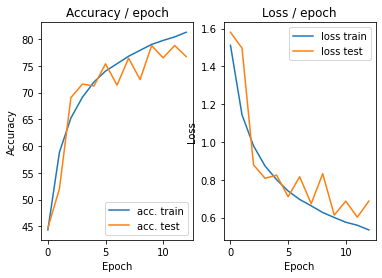

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.207s (0.207s)	Loss 0.5376 (0.5376)	Prec@1  78.9 ( 78.9)	Prec@5  99.2 ( 99.2)


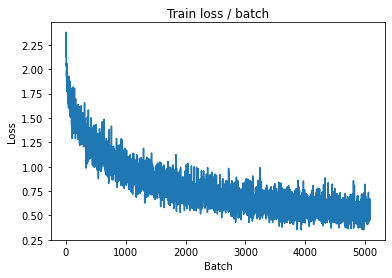

[TRAIN Batch 200/391]	Time 0.018s (0.036s)	Loss 0.4403 (0.5207)	Prec@1  83.6 ( 82.1)	Prec@5  99.2 ( 99.1)


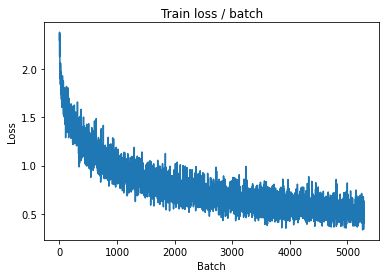


===============> Total time 14s	Avg loss 0.5205	Avg Prec@1 81.98 %	Avg Prec@5 99.13 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 0.4610 (0.4610)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)

===============> Total time 2s	Avg loss 0.5271	Avg Prec@1 81.84 %	Avg Prec@5 99.17 %



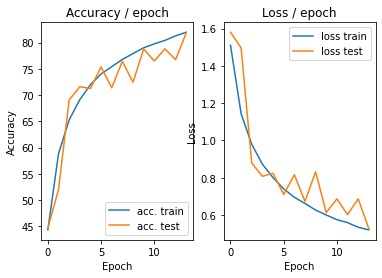

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.200s (0.200s)	Loss 0.4990 (0.4990)	Prec@1  82.0 ( 82.0)	Prec@5  98.4 ( 98.4)


[TRAIN Batch 200/391]	Time 0.016s (0.036s)	Loss 0.4064 (0.4979)	Prec@1  84.4 ( 82.5)	Prec@5 100.0 ( 99.2)


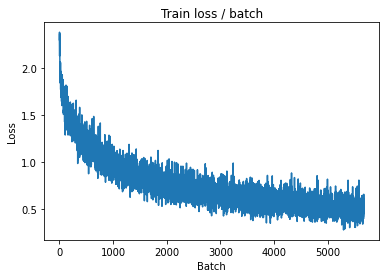


===============> Total time 13s	Avg loss 0.5012	Avg Prec@1 82.40 %	Avg Prec@5 99.20 %

[EVAL Batch 000/079]	Time 0.168s (0.168s)	Loss 0.4971 (0.4971)	Prec@1  81.2 ( 81.2)	Prec@5 100.0 (100.0)

===============> Total time 2s	Avg loss 0.6035	Avg Prec@1 78.77 %	Avg Prec@5 98.90 %



=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.273s (0.273s)	Loss 0.5305 (0.5305)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


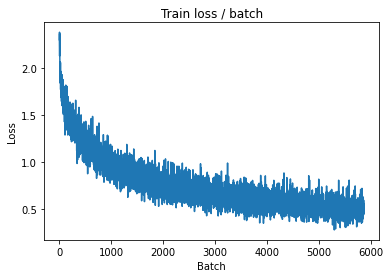

[TRAIN Batch 200/391]	Time 0.061s (0.038s)	Loss 0.4560 (0.4758)	Prec@1  85.2 ( 83.4)	Prec@5  97.7 ( 99.3)


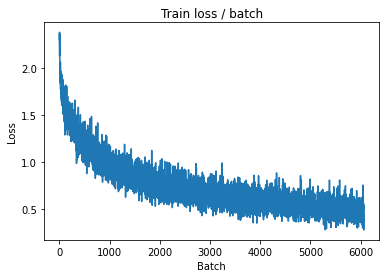


===============> Total time 14s	Avg loss 0.4868	Avg Prec@1 83.01 %	Avg Prec@5 99.25 %

[EVAL Batch 000/079]	Time 0.186s (0.186s)	Loss 0.5490 (0.5490)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6363	Avg Prec@1 78.70 %	Avg Prec@5 99.05 %



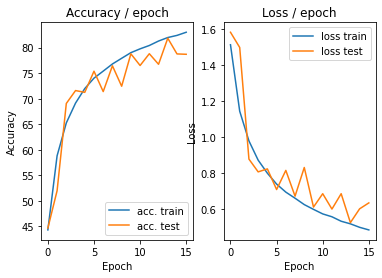

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.180s (0.180s)	Loss 0.3871 (0.3871)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


[TRAIN Batch 200/391]	Time 0.026s (0.036s)	Loss 0.3733 (0.4785)	Prec@1  87.5 ( 83.4)	Prec@5  99.2 ( 99.3)



===============> Total time 14s	Avg loss 0.4762	Avg Prec@1 83.43 %	Avg Prec@5 99.29 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 0.4404 (0.4404)	Prec@1  85.2 ( 85.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5646	Avg Prec@1 79.84 %	Avg Prec@5 98.99 %



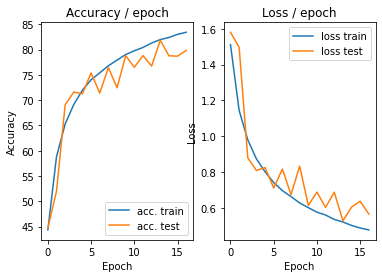

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.201s (0.201s)	Loss 0.6299 (0.6299)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)


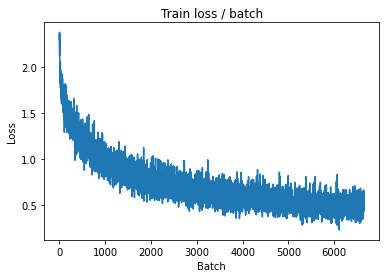

[TRAIN Batch 200/391]	Time 0.069s (0.046s)	Loss 0.5350 (0.4664)	Prec@1  78.9 ( 83.6)	Prec@5  98.4 ( 99.4)


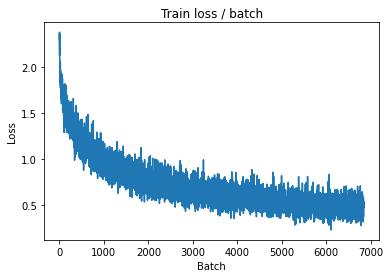


===============> Total time 15s	Avg loss 0.4641	Avg Prec@1 83.80 %	Avg Prec@5 99.36 %

[EVAL Batch 000/079]	Time 0.176s (0.176s)	Loss 0.4595 (0.4595)	Prec@1  85.2 ( 85.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5874	Avg Prec@1 79.97 %	Avg Prec@5 98.90 %



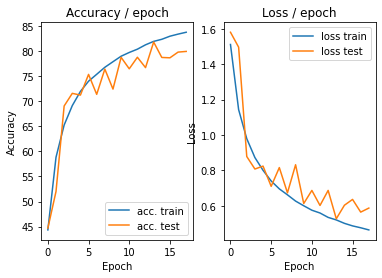

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.193s (0.193s)	Loss 0.3437 (0.3437)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)


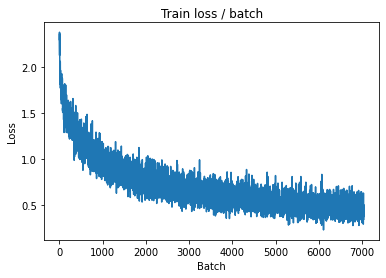

[TRAIN Batch 200/391]	Time 0.016s (0.037s)	Loss 0.4417 (0.4509)	Prec@1  87.5 ( 84.1)	Prec@5 100.0 ( 99.4)



===============> Total time 14s	Avg loss 0.4531	Avg Prec@1 84.17 %	Avg Prec@5 99.39 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 0.4028 (0.4028)	Prec@1  85.9 ( 85.9)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5241	Avg Prec@1 82.01 %	Avg Prec@5 99.00 %



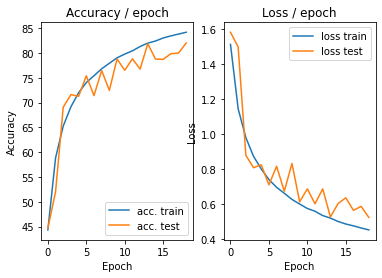

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.188s (0.188s)	Loss 0.4229 (0.4229)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


[TRAIN Batch 200/391]	Time 0.104s (0.041s)	Loss 0.4338 (0.4396)	Prec@1  82.8 ( 84.7)	Prec@5  99.2 ( 99.4)


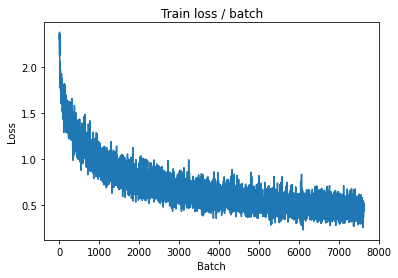


===============> Total time 15s	Avg loss 0.4381	Avg Prec@1 84.64 %	Avg Prec@5 99.42 %

[EVAL Batch 000/079]	Time 0.180s (0.180s)	Loss 0.4094 (0.4094)	Prec@1  86.7 ( 86.7)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5122	Avg Prec@1 82.50 %	Avg Prec@5 99.03 %



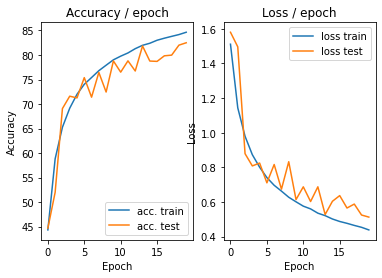

In [17]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

main(128, 0.1, cuda=True, epochs=20)